In [1]:
from copy import deepcopy
from dataclasses import dataclass
from typing import Literal

import numpy as np
from numpy.typing import NDArray

import sklearn as skl
import torch as pt

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns


sns.set_theme(style='darkgrid', palette='muted')

In [2]:
from sklearn.datasets import make_classification

from torch.utils import data


@dataclass()
class Dataset(data.Dataset):
    x: pt.Tensor
    y: pt.Tensor

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __iter__(self):
        return zip(self.x, self.y)

    def __len__(self):
        return self.x.shape[0]

    def __repr__(self):
        return f'{type(self)}({self.x.shape})'


def make_dataset(train: int, test: int, sample: int):
    n_samples = train + test + sample

    #generate dataset with n_sameples data and 20 features
    x, y = make_classification(n_samples, random_state=42)
    print(x.shape)

    x = pt.tensor(x, dtype=pt.float)
    #do the transpose
    y = pt.tensor(y[..., None], dtype=pt.float)
    # y = pt.tensor(y, dtype=pt.float)
    # print(x)
    # print(y)

    #do the dataset slice
    i_train = np.s_[:train]
    i_test = np.s_[train:train+test]
    i_sample = np.s_[train+test:]
    d_train = Dataset(x[i_train], y[i_train])
    d_test = Dataset(x[i_test], y[i_test])
    d_sample = Dataset(x[i_sample], y[i_sample])
    return d_train, d_test, d_sample


train, test, sample = make_dataset(100, 100, 2000)
print(train.x.shape)


(2200, 20)
torch.Size([100, 20])


In [3]:
from torch import nn, optim


class LogisticRegression(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        x = self.sigmoid(x)
        return x


model = LogisticRegression(train.x.shape[1], 1)
loss_list = []

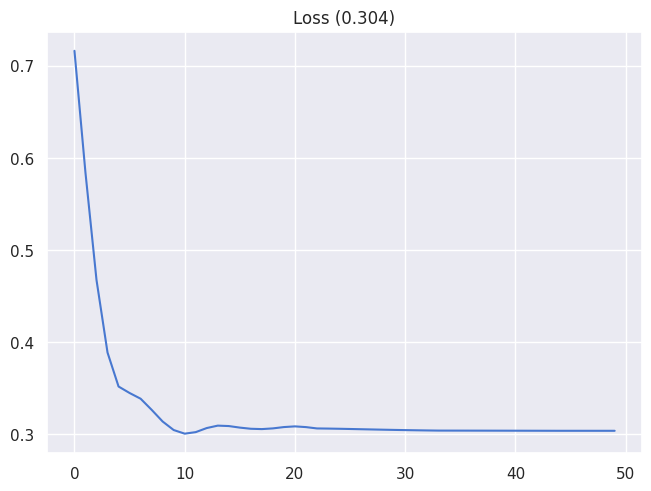

In [4]:
def draw_statistic(*args, mode: Literal['both', 'loss', 'acc'] = 'loss'):
    fig: plt.Figure
    ax: plt.Axes
    ax0: plt.Axes
    ax1: plt.Axes
    if mode == 'both':
        fig, (ax0, ax1) = plt.subplots(
            1, 2,
            sharex=True,
            figsize=(10, 5),
            layout='constrained'
        )
        ax0.plot(args[0], c='C0')
        ax1.plot(args[1], c='C1')
        ax0.set_title(f'Loss ({args[0][-1]:.3f})')
        ax1.set_title(f'Accuracy ({args[1][-1]:.1%})')
    elif mode == 'loss':
        fig, ax = plt.subplots(1, 1, layout='constrained')
        ax.plot(args[0])
        ax.set_title(f'Loss ({args[0][-1]:.3f})')
    elif mode == 'acc':
        fig, ax = plt.subplots(1, 1, layout='constrained')
        ax.plot(args[0])
        ax.set_title(f'Accuracy ({args[0][-1]:.1%})')
    else:
        raise ValueError('mode must be one of both, loss, or acc')


# def training(model: nn.Module, dataset: Dataset, max_epochs: int, loss_list: list | None = None):
def training(model: nn.Module, dataset: Dataset, max_epochs: int, loss_list: list = None):
    loss: pt.Tensor
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), 0.3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    model.train()
    for _ in range(max_epochs):
        outputs = model(dataset.x)
        optimizer.zero_grad()
        loss = criterion(outputs, dataset.y)
        loss.backward()
        optimizer.step()
        # optimizer.zero_grad()
        scheduler.step(loss)
        if loss_list is not None:
            loss_list.append(loss.item())
    model.eval()


training(model, train, 50, loss_list)
draw_statistic(loss_list, mode='loss')

In [5]:
class Recourse(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.action = nn.Parameter(pt.zeros(size))

    # def forward(self, x: pt.Tensor, weight: pt.Tensor | None = None):
    def forward(self, x: pt.Tensor, weight: pt.Tensor = None):
        a = self.action
        # print("a",a)

        #to be implement
        #add cost funtion weight

        if weight is not None:
            a = a * weight
        x = x + a
        return x


# def recourse(c_model: nn.Module, dataset: Dataset, max_epochs: int, weight: pt.Tensor | None = None, loss_list: list | None = None):
def recourse(c_model: nn.Module, dataset: Dataset, max_epochs: int, weight: pt.Tensor = None, loss_list: list = None):
    loss: pt.Tensor
    r_model = Recourse(dataset.x.shape)
    criterion = nn.HuberLoss()
    optimizer = optim.Adam(r_model.parameters(), 0.1)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

    r_model.train()
    for _ in range(max_epochs):
        optimizer.zero_grad()
        x_hat = r_model(dataset.x, weight)
        y_hat = c_model(x_hat)
        loss = criterion(y_hat, dataset.y)
        loss.backward()
        optimizer.step()
        # optimizer.zero_grad()
        c_model.zero_grad()
        # scheduler.step(loss)
        if loss_list is not None:
            loss_list.append(loss.item())
    r_model.eval()

    with pt.no_grad():
        dataset.x = r_model(dataset.x)

In [6]:
a = nn.Parameter(pt.zeros(train.x.shape))
print(a)
print(a.shape)
# print(model.parameters())
for name,param in model.named_parameters():
    print(name,param)

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)
torch.Size([100, 20])
linear.weight Parameter containing:
tensor([[-0.2420, -0.7379,  0.1967, -0.5761,  0.1174, -2.6420, -0.0853,  0.2909,
         -0.6525, -0.0717, -1.7077,  0.4762,  0.3132,  0.1547,  1.6339,  0.6079,
          0.2594, -0.7672,  2.9945, -0.0805]], requires_grad=True)
linear.bias Parameter containing:
tensor([-0.1605], requires_grad=True)


In [7]:
from sklearn.decomposition import PCA

pca = PCA(2).fit(train.x)

In [12]:
from matplotlib.animation import FuncAnimation
from matplotlib.axes import Axes
from matplotlib.figure import Figure, SubFigure
from matplotlib.colors import ListedColormap
from matplotlib.collections import PathCollection
from matplotlib.container import BarContainer
from matplotlib.contour import QuadContourSet
from matplotlib.patches import Rectangle


class PlotHelper:

    palette = sns.color_palette('muted', 2)
    cmap = ListedColormap(palette)

    def __init__(self, model: nn.Module, pca: PCA, train: Dataset, test: Dataset, sample: Dataset):
        self.model = model
        self.pca = pca
        self.train = train
        self.test = test
        self.sample = sample
        self.PDt = []
        self.round = 0
        self.EFTdataframe =  pd.DataFrame(
            {
                'x':train.x.tolist(),
                'y':train.y.flatten(),
                # 'Predict':train.y.flatten(),
                'Predict':[[] for _ in range(len(train.x))],
                'flip_times':np.zeros(len(train.x)),
                'startRounds':np.zeros(len(train.x)),
                'updateRounds':np.zeros(len(train.x)),
                'EFT' : np.zeros(len(train.x)),
                'EFTList': [[] for _ in range(len(train.x))]
            }
        )
        self.failToRecourse = []

        self.validation_list = []
        self.Ajj_performance_list = []
        self.overall_acc_list = []
        self.memory_stability_list = []
        self.memory_plasticity_list = []
        self.Aj_tide_list = []

        self._hist: list[BarContainer]
        self._bins: NDArray
        self._sc_train: PathCollection
        self._sc_test: PathCollection
        self._ct_test: QuadContourSet

    # def draw_proba_hist(self, ax: Axes | None = None, *, label: bool = False):
    def draw_proba_hist(self, ax: Axes = None, *, label: bool = False):
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 4))
        else:
            fig = ax.get_figure()

        x = self.test.x
        y = self.test.y

        n = x.shape[0]
        m = n - pt.count_nonzero(y)

        with pt.no_grad():
            y_prob: pt.Tensor = self.model(x)

        y = y.flatten()
        y_prob = y_prob.flatten()
        y_prob = y_prob[y.argsort()]

        w = np.broadcast_to(100 / n, n)

        self._hist: list[BarContainer]
        _, self._bins, self._hist = ax.hist(
            (y_prob[:m], y_prob[m:]),
            10,
            (0, 1),
            weights=(w[:m], w[m:]),
            rwidth=1,
            color=self.palette,
            label=(0, 1),
            ec='w',
            alpha=0.9,
        )

        ax.legend(loc='upper center', title='True label')
        ax.set_xlabel('mean predicted probabilty')
        ax.set_ylabel('percent')
        ax.set_title('Probability Distribution')

        if label:
            for c in self._hist:
                height = map(Rectangle.get_height, c.patches)
                ax.bar_label(
                    c,
                    [f'{h}%' if h else '' for h in height],
                    fontsize='xx-small'
                )
        return fig, ax

    # def draw_dataset_scatter(self, axes: tuple[Axes, Axes] | None = None):
    def draw_dataset_scatter(self, axes: [Axes, Axes] = None):
        if axes is None:
            fig, (ax0, ax1) = plt.subplots(
                1, 2,
                sharex=True,
                sharey=True,
                figsize=(8, 4),
                layout='compressed'
            )
        else:
            ax0, ax1 = axes
            fig = ax0.get_figure()

        prop = dict(cmap=self.cmap, s=40, vmin=0., vmax=1., lw=0.8, ec='w')

        self._sc_train = ax0.scatter(
            *pca.transform(self.train.x).T,
            c=self.train.y,
            **prop
        )
        ax0.legend(
            *self._sc_train.legend_elements(),
            loc='upper right',
            title='True label'
        )
        ax0.set_xlabel('pca0')
        ax0.set_ylabel('pca1')
        ax0.set_title('Train')

        with pt.no_grad():
            y_prob: pt.Tensor = self.model(test.x)

        y_prob = y_prob.flatten()
        y_pred = y_prob.greater(0.5)

        self._sc_test = ax1.scatter(
            *pca.transform(test.x).T,
            c=y_pred,
            **prop
        )
        ax1.legend(
            *self._sc_test.legend_elements(),
            loc='upper right',
            title='Predicted'
        )

        x0, x1 = ax0.get_xlim()
        y0, y1 = ax0.get_ylim()
        n = 32
        xy = np.mgrid[x0: x1: n * 1j, y0: y1: n * 1j]
        z = pca.inverse_transform(xy.reshape(2, n * n).T)

        z = pt.tensor(z, dtype=pt.float)
        with pt.no_grad():
            z: pt.Tensor = self.model(z)
        z = z.view(n, n)
        self._ct_test = ax1.contourf(
            *xy, z, 10,
            cmap='RdYlBu_r',
            vmin=0,
            vmax=1,
            alpha=0.9,
            zorder=0,
        )
        fig.colorbar(self._ct_test, ax=ax1, label='probability')
        ax1.grid(alpha=0.75)
        ax1.set_xlabel('pca0')
        ax1.set_title('Test')

        return fig, axes

    def draw_all(self):
        sf: list[SubFigure]
        fig = plt.figure(figsize=(8, 8), layout='constrained')
        sf = fig.subfigures(2, 1)
        ax0 = sf[0].subplots()
        ax1, ax2 = sf[1].subplots(1, 2, sharex=True, sharey=True)
        self.draw_proba_hist(ax0)
        self.draw_dataset_scatter((ax1, ax2))
        return fig, (ax0, ax1, ax2)

    def animate_all(self, frames: int = 120, fps: int = 10, *, inplace: bool = False):
        fig, (ax0, ax1, ax2) = self.draw_all()

        model = self.model if inplace else deepcopy(self.model)
        train = self.train if inplace else deepcopy(self.train)
        test = self.test
        sample = self.sample

        def init():
            return *ax0.patches, *ax1.collections, *ax2.collections

        def func(frame):
            fig.suptitle(f'No. {frame}', ha='left', x=0.01, size='small')

            if frame == 0:
                return ()

            self.update(model, train, sample)

            y = test.y.flatten()

            n = test.x.shape[0]
            m = n - pt.count_nonzero(y)

            with pt.no_grad():
                y_prob: pt.Tensor = model(test.x)

            y_prob = y_prob.flatten()
            y_pred = y_prob.greater(0.5)
            rank = y_prob[y.argsort()]

            for b, r in zip(self._hist, (rank[:m], rank[m:])):
                height, _ = np.histogram(r, self._bins)
                for r, h in zip(b.patches, height * (100 / n)):
                    r.set_height(h)

            self._sc_train.set_offsets(pca.transform(train.x))
            self._sc_train.set_array(train.y.flatten())
            self._sc_test.set_array(y_pred)

            ax1.relim()
            ax1.autoscale_view()

            for c in self._ct_test.collections:
                c.remove()

            x0, x1 = ax1.get_xlim()
            y0, y1 = ax1.get_ylim()
            n = 32
            xy = np.mgrid[x0: x1: n * 1j, y0: y1: n * 1j]
            z = pca.inverse_transform(xy.reshape(2, n * n).T)
            z = pt.tensor(z, dtype=pt.float)
            with pt.no_grad():
                z: pt.Tensor = model(z)
            z = z.view(n, n)

            self._ct_test: QuadContourSet = ax2.contourf(
                *xy, z, 10,
                cmap='RdYlBu_r',
                vmin=0,
                vmax=1,
                alpha=0.9,
                zorder=0,
            )

            return *ax0.patches, *ax1.collections, *ax2.collections

        return FuncAnimation(
            fig, func, frames, init,
            interval=1000 // fps,
            repeat=False,
            blit=True,
            cache_frame_data=False
        )

    def draw_PDt(self):

        #每一個round算出來的L2 distance
        tempList = deepcopy(self.PDt)
        # print("PDt: ",self.PDt)
        # print("tempList: ",tempList)
        # [1,2,3,4,5]
        for index,i in enumerate(range(len(self.PDt))):
            temp = 0.0
            #算出PDt
            for j in range(i + 1):
                temp = temp + tempList[j]
            temp = temp / (index + 1)
            # print("temp: ",temp)
            # print(type(temp))
            self.PDt[index] = temp

        # print("self.PDt: ",self.PDt)

        plt.figure()
        plt.plot(self.PDt)
        plt.xlabel('Round')
        plt.ylabel('PDt')
        plt.title('PDt during Rounds')
        plt.draw()

    def draw_EFT(self,epochs):
        data = []
        labels = [(epochs / 10 - 1) * (i+1) for i in range(10)]
        x = [1,2,3,4,5,6,7,8,9,10]
        # labels = [8 * (i+1) for i in range(12)]
        # x = [1,2,3,4,5,6,7,8,9,10,11,12]
        for i in range((int(epochs / 10)-1),epochs - 1,(int(epochs / 10) - 1)):
        # for i in range(8,100,8):
            # print("i",i)
            roundData = []
            #只顯示經過2輪以上update的model的資料
            # dataframe = self.EFTdataframe[self.EFTdataframe['updateRounds'] > 2]
            dataframe = self.EFTdataframe[i - self.EFTdataframe['startRounds'] >= 2]
            # dataframe = self.EFTdataframe[self.EFTdataframe['flip_times'] > 0].head(10)
            for j in dataframe.index:
                # print("index: ",j)
                #判斷開始的Round是否合理
                if dataframe.at[j,'startRounds'] < i:
                    # print("index j append: ",j)
                    temp = dataframe.at[j,'EFTList']
                    roundData.append(temp[i - 1])
                # data.append([temp[i]])
                # self.EFTdataframe.at[i,'EFPList'].append(self.EFTdataframe.at[i,'flip_times'] / self.EFTdataframe.at[i,'rounds'])
            # print(data)
            data.append(roundData)
        plt.figure()
        # sns.boxplot(x='rounds',y='EFPList',data = self.EFTdataframe)
        plt.boxplot(data)
        plt.xticks(x,labels)
        plt.xlabel('Round')
        plt.ylabel('EFT')

    def calculateR20EFT(self,tempPredict,updateRounds):
        last = tempPredict[0]
        flipTimes = 0
        for i in range(len(tempPredict) - 1):
            if(last != tempPredict[i + 1]):
                flipTimes += 1
            last = tempPredict[i + 1]
        # print("R20_EFT value: ",flipTimes / updateRounds)
        return flipTimes / updateRounds

    def draw_R20_EFT(self,epochs,intervalRounds):
        data = []
        labels = [i for i in range(intervalRounds,epochs,intervalRounds)]
        x = [i for i in range(1,len(labels) + 1)]
        # labels = [(int(epochs / 10) - 1) * (i+1) for i in range(10)]
        # x = [1,2,3,4,5,6,7,8,9,10]

        # for i in range((int(epochs / 10)-1),epochs - 1,(int(epochs / 10) - 1)):
        for i in range(intervalRounds,epochs - 1,intervalRounds):
            # print("i's round:",i)
            roundData = []
            # dataframe = self.EFTdataframe[self.EFTdataframe['updateRounds'] > 2]
            dataframe = self.EFTdataframe[i - self.EFTdataframe['startRounds'] >= 2]
            # print("R20's EFTdataframe")
            # display(dataframe)
            for j in dataframe.index:
                startRounds = int(dataframe.at[j,'startRounds'])
                if startRounds < i:
                    #dataframe['Predict'][0]代表從第predictRound開始做預測
                    # print("startRound : ",startRounds)

                    if startRounds >= i - intervalRounds:
                        startIndex = 0
                    else:
                        # startIndex = ((i - (int(epochs / 10) - 1)) - startRounds) - 1
                        startIndex = ((i - intervalRounds) - startRounds) - 1

                    endIndex = (i - startRounds)
                    # print("Predict array: ",dataframe.at[j,'Predict'])
                    # print("startIndex: ",startIndex)
                    # print("endIndex : ",endIndex)
                    tempPredict = dataframe.at[j,'Predict'][startIndex:endIndex]

                    roundData.append(self.calculateR20EFT(tempPredict,len(tempPredict)))


            data.append(roundData)
        plt.figure()
        # sns.boxplot(x='rounds',y='EFPList',data = self.EFTdataframe)
        plt.boxplot(data)
        plt.xticks(x,labels)
        plt.xlabel('Round')
        plt.ylabel('R20_EFT')

    def draw_Fail_to_Recourse(self):
        plt.figure()
        plt.plot(self.failToRecourse)
        plt.xlabel('Round')
        plt.ylabel('Fail_to_Recourse')
        plt.title('FtR during Rounds')
        plt.draw()

    #紀錄新增進來的sample資料
    def addEFTDataFrame(self,index):
        if self.EFTdataframe.at[0,'updateRounds'] != 0:
            sampleDataframe =  pd.DataFrame(
                {
                    'x':self.train.x[index].tolist(),
                    'y':self.train.y[index].flatten(),
                    # 'Predict':np.nan,
                    # 'Predict':self.train.y[index].flatten(),
                    'Predict':[ [] for _ in range(len(train.y[index]))],
                    'flip_times':np.zeros(len(self.train.y[index])),
                    'startRounds':np.full(len(self.train.y[index]),int(self.EFTdataframe.at[0,'updateRounds'])),
                    'updateRounds':np.zeros(len(self.train.y[index])),
                    'EFT' : np.zeros(len(self.train.y[index])),
                    # 'EFPList': [np.zeros(int(self.EFTdataframe.at[0,'rounds'])) for _ in range(len(train.y[index]))]
                    'EFTList': [ [0.0] * int(self.EFTdataframe.at[0,'updateRounds']) for _ in range(len(self.train.y[index]))]
                }
            )
        else:
            sampleDataframe =  pd.DataFrame(
                {
                    'x':self.train.x[index].tolist(),
                    'y':self.train.y[index].flatten(),
                    # 'Predict':np.nan,
                    # 'Predict':self.train.y[index].flatten(),
                    'Predict':[ [] for _ in range(len(train.y[index]))],
                    'flip_times':np.zeros(len(self.train.y[index])),
                    'startRounds':np.zeros(len(self.train.y[index])),
                    'updateRounds':np.zeros(len(self.train.y[index])),
                    'EFT' : np.zeros(len(self.train.y[index])),
                    'EFTList': [ [] for _ in range(len(self.train.y[index]))]
                }
            )
        # display(sampleDataframe)
        self.EFTdataframe = pd.concat([self.EFTdataframe,sampleDataframe],ignore_index=True)

    def calculate_accuracy(self, predicted_results, actual_labels, threshold=0.5):
      # Convert probabilities to binary predictions based on the threshold
      binary_predictions = []
      for prob in predicted_results:
        pred_label = 0
        if prob >= threshold:
          pred_label = 1
        else:
          pred_label = 0
        binary_predictions.append(pred_label)

      # Compare binary predictions to actual labels
      correct_predictions = []
      for i in range(0, len(binary_predictions)):
        if(binary_predictions[i] == actual_labels[i]):
          correct_predictions.append(1)
        else:
          correct_predictions.append(0)

      # Calculate accuracy as the ratio of correct predictions to total predictions
      if len(correct_predictions) == 0:
        return 0
      accuracy = sum(correct_predictions) / len(correct_predictions)
      return accuracy

    def calculate_AA(self, kth_model: nn.Module, jth_data_after_recourse: list):
      if jth_data_after_recourse:
        kth_model.eval()
        sum = 0

        # do each historical task
        for j in jth_data_after_recourse:
          pred = kth_model(j.x)
          acc = self.calculate_accuracy(pred, j.y)
          sum += acc

        return sum / len(jth_data_after_recourse)

      print("jth_data_after_recourse cannot be empty")
      return None

    def calculate_BWT(self, kth_model: nn.Module, jth_data_after_recourse, Ajj_performance_list):
      kth_model.eval()
      sum = 0

      for i in range (0, len(jth_data_after_recourse)):
        # if is the last loop, calculate A(j,j) and store it
        if i == len(jth_data_after_recourse) - 1:
          pred = kth_model(jth_data_after_recourse[i].x)
          Ajj_performance_list.append(self.calculate_accuracy(pred, jth_data_after_recourse[-1].y))
        # else we calculate A(k,j) - A(j,j)
        else:
          pred = kth_model(jth_data_after_recourse[i].x)
          acc = self.calculate_accuracy(pred, jth_data_after_recourse[i].y) - Ajj_performance_list[i]
          sum += acc

      if len(jth_data_after_recourse) == 1:
        return sum
      return sum / (len(jth_data_after_recourse) - 1)

    def calculate_FWT(self, Ajj_performance_list, Aj_tide_list):
      sum = 0

      for i in range(1, len(Ajj_performance_list)):
        sum +=  Ajj_performance_list[i] - Aj_tide_list[i]
        print(Ajj_performance_list[i], Aj_tide_list[i])
      if len(Aj_tide_list) == 1:
        return sum
      return sum / (len(Aj_tide_list) - 1)

    def plot_matricsA(self):
      # Create a figure and subplots
      fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

      # Plot data on each subplot and draw
      axs[0].plot(self.overall_acc_list)
      axs[0].set_title('avarage accuracy')
      axs[0].set_xlabel('Round')
      axs[0].set_ylabel('accuracy')

      axs[1].plot(self.memory_stability_list)
      axs[1].set_title('memory stability (BWT)')
      axs[1].set_xlabel('Round')
      axs[1].set_ylabel('memory stability')

      axs[2].plot(self.memory_plasticity_list)
      axs[2].set_title('memory plasticity')
      axs[2].set_xlabel('Round')
      axs[2].set_ylabel('memory plasticity')

      # Adjust layout
      plt.tight_layout()

      # Show plot
      plt.show()

    def update(self, model: nn.Module, train: Dataset, sample: Dataset):
        raise NotImplementedError()


# helper = PlotHelper(model, pca, train, test, sample)
# helper.draw_all()
# plt.show()

,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,[1.0],0.0,0.0,1.0,0.0,[]
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,[1.0],0.0,0.0,1.0,0.0,[]
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,[1.0],0.0,0.0,1.0,0.0,[]
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,[1.0],0.0,0.0,1.0,0.0,[]
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,[1.0],0.0,0.0,1.0,0.0,[]
...,...,...,...,...,...,...,...,...
120,"[0.08189667761325836, 0.05966189503669739, 2.0...",1.0,[1.0],0.0,0.0,1.0,0.0,[]
121,"[-0.8128235936164856, -2.074486255645752, 1.62...",0.0,[1.0],0.0,0.0,1.0,0.0,[]
122,"[0.0863986387848854, -1.3315123319625854, 2.34...",1.0,[1.0],0.0,0.0,1.0,0.0,[]
123,"[0.6233422756195068, -0.9766203165054321, -1.1...",0.0,[0.0],0.0,0.0,1.0,0.0,[]


0.88 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0]",0.0,0.0,2.0,0.0,[0.0]
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0]",1.0,0.0,2.0,1.0,[1.0]
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0]",0.0,0.0,2.0,0.0,[0.0]
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0]",1.0,0.0,2.0,1.0,[1.0]
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0]",0.0,0.0,2.0,0.0,[0.0]
...,...,...,...,...,...,...,...,...
145,"[0.2517852485179901, 1.760043740272522, -1.620...",0.0,[0.0],0.0,1.0,1.0,0.0,[0.0]
146,"[-2.1027016639709473, 0.4215136468410492, 0.33...",1.0,[0.0],0.0,1.0,1.0,0.0,[0.0]
147,"[0.5090683698654175, 0.1449059396982193, 1.883...",0.0,[0.0],0.0,1.0,1.0,0.0,[0.0]
148,"[0.30193063616752625, 1.0386543273925781, -0.4...",1.0,[0.0],0.0,1.0,1.0,0.0,[0.0]


0.88 1.0
1.0 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0]",0.0,0.0,3.0,0.0,"[0.0, 0.0]"
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0]",2.0,0.0,3.0,1.0,"[1.0, 1.0]"
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0]",1.0,0.0,3.0,0.5,"[0.0, 0.5]"
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0]",2.0,0.0,3.0,1.0,"[1.0, 1.0]"
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0]",0.0,0.0,3.0,0.0,"[0.0, 0.0]"
...,...,...,...,...,...,...,...,...
170,"[-0.7133108973503113, 1.7347627878189087, 0.43...",0.0,[0.0],0.0,2.0,1.0,0.0,"[0.0, 0.0]"
171,"[-1.2159669399261475, -0.041672736406326294, -...",1.0,[1.0],0.0,2.0,1.0,0.0,"[0.0, 0.0]"
172,"[1.4538590908050537, -0.31241732835769653, -0....",1.0,[1.0],0.0,2.0,1.0,0.0,"[0.0, 0.0]"
173,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,[1.0],0.0,2.0,1.0,0.0,"[0.0, 0.0]"


0.88 1.0
1.0 1.0
0.76 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0]",0.0,0.0,4.0,0.000000,"[0.0, 0.0, 0.0]"
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0]",2.0,0.0,4.0,0.666667,"[1.0, 1.0, 0.6666666666666666]"
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0]",1.0,0.0,4.0,0.333333,"[0.0, 0.5, 0.3333333333333333]"
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0]",2.0,0.0,4.0,0.666667,"[1.0, 1.0, 0.6666666666666666]"
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0]",0.0,0.0,4.0,0.000000,"[0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...
195,"[0.7854825854301453, 1.4801831245422363, -0.34...",0.0,[1.0],0.0,3.0,1.0,0.000000,"[0.0, 0.0, 0.0]"
196,"[-1.925642967224121, -0.4310844838619232, 1.27...",1.0,[1.0],0.0,3.0,1.0,0.000000,"[0.0, 0.0, 0.0]"
197,"[-0.03914402797818184, 1.0752215385437012, -0....",0.0,[0.0],0.0,3.0,1.0,0.000000,"[0.0, 0.0, 0.0]"
198,"[-0.37439003586769104, -1.5144140720367432, -0...",0.0,[0.0],0.0,3.0,1.0,0.000000,"[0.0, 0.0, 0.0]"


0.88 1.0
1.0 1.0
0.76 1.0
0.92 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0]",0.0,0.0,5.0,0.00,"[0.0, 0.0, 0.0, 0.0]"
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0]",2.0,0.0,5.0,0.50,"[1.0, 1.0, 0.6666666666666666, 0.5]"
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0]",1.0,0.0,5.0,0.25,"[0.0, 0.5, 0.3333333333333333, 0.25]"
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0]",2.0,0.0,5.0,0.50,"[1.0, 1.0, 0.6666666666666666, 0.5]"
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0]",0.0,0.0,5.0,0.00,"[0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...
220,"[0.2517852485179901, 1.760043740272522, -1.620...",0.0,[0.0],0.0,4.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0]"
221,"[0.759442150592804, 0.27982160449028015, 0.565...",1.0,[1.0],0.0,4.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0]"
222,"[-1.925642967224121, -0.4310844838619232, 1.27...",1.0,[1.0],0.0,4.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0]"
223,"[-1.9158689975738525, -0.43840888142585754, -0...",1.0,[1.0],0.0,4.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0]"


0.88 1.0
1.0 1.0
0.76 1.0
0.92 1.0
0.92 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.0,0.0,6.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0]"
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0]",3.0,0.0,6.0,0.6,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.6]"
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0]",2.0,0.0,6.0,0.4,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.4]"
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0]",2.0,0.0,6.0,0.4,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.4]"
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.0,0.0,6.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...
245,"[1.256520390510559, -0.7665912508964539, -1.08...",1.0,[0.0],0.0,5.0,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0]"
246,"[-0.2596779763698578, 1.002809762954712, 1.662...",1.0,[0.0],0.0,5.0,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0]"
247,"[-0.3117977976799011, -1.7473630905151367, 0.2...",1.0,[1.0],0.0,5.0,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0]"
248,"[0.2517852485179901, 1.760043740272522, -1.620...",0.0,[0.0],0.0,5.0,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0]"


0.88 1.0
1.0 1.0
0.76 1.0
0.92 1.0
0.92 1.0
1.0 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.0,0.0,7.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0]",3.0,0.0,7.0,0.500000,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.6, 0.5]"
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0]",2.0,0.0,7.0,0.333333,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.33..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]",2.0,0.0,7.0,0.333333,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.333..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.0,0.0,7.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...
270,"[0.78657066822052, 1.7073811292648315, 0.36712...",1.0,[1.0],0.0,6.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
271,"[0.5484632849693298, -0.1604500412940979, 0.76...",0.0,[0.0],0.0,6.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
272,"[-2.191253900527954, -0.45976462960243225, -0....",0.0,[0.0],0.0,6.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
273,"[0.9964319467544556, -1.4920862913131714, 0.40...",1.0,[1.0],0.0,6.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


0.88 1.0
1.0 1.0
0.76 1.0
0.92 1.0
0.92 1.0
1.0 1.0
0.84 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.0,0.0,8.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0]",4.0,0.0,8.0,0.571429,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.6, 0.5, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0]",3.0,0.0,8.0,0.428571,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.33..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]",3.0,0.0,8.0,0.428571,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.333..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.0,0.0,8.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...
295,"[1.256520390510559, -0.7665912508964539, -1.08...",1.0,[1.0],0.0,7.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
296,"[0.3530392348766327, -0.8320704698562622, 0.16...",0.0,[0.0],0.0,7.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
297,"[0.8569755554199219, -0.18509764969348907, 0.9...",0.0,[0.0],0.0,7.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
298,"[-0.7133108973503113, 1.7347627878189087, 0.43...",0.0,[0.0],0.0,7.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


0.88 1.0
1.0 1.0
0.76 1.0
0.92 1.0
0.92 1.0
1.0 1.0
0.84 1.0
0.92 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]",1.0,0.0,9.0,0.125,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125]"
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]",4.0,0.0,9.0,0.500,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.6, 0.5, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0]",3.0,0.0,9.0,0.375,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.33..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0]",4.0,0.0,9.0,0.500,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.333..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.0,0.0,9.0,0.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...
320,"[-0.23778893053531647, -0.5849044322967529, 0....",1.0,[1.0],0.0,8.0,1.0,0.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
321,"[-0.8929905295372009, 1.6021312475204468, -0.3...",0.0,[1.0],0.0,8.0,1.0,0.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
322,"[-1.522334337234497, 0.012169682420790195, -2....",0.0,[0.0],0.0,8.0,1.0,0.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
323,"[0.9172489047050476, 1.168365240097046, 0.1266...",1.0,[1.0],0.0,8.0,1.0,0.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


0.88 1.0
1.0 1.0
0.76 1.0
0.92 1.0
0.92 1.0
1.0 1.0
0.84 1.0
0.92 1.0
1.0 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",2.0,0.0,10.0,0.222222,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",4.0,0.0,10.0,0.444444,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.6, 0.5, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",4.0,0.0,10.0,0.444444,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.33..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",5.0,0.0,10.0,0.555556,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.333..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.0,0.0,10.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...
345,"[-1.2159669399261475, -0.041672736406326294, -...",1.0,[0.0],0.0,9.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
346,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,[1.0],0.0,9.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
347,"[0.780222475528717, 0.2059607207775116, 0.7508...",1.0,[0.0],0.0,9.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
348,"[0.0779372975230217, 1.11386239528656, -1.1041...",0.0,[0.0],0.0,9.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


0.88 1.0
1.0 1.0
0.76 1.0
0.92 1.0
0.92 1.0
1.0 1.0
0.84 1.0
0.92 1.0
1.0 1.0
0.92 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",2.0,0.0,11.0,0.2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",5.0,0.0,11.0,0.5,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.6, 0.5, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",4.0,0.0,11.0,0.4,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.33..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",5.0,0.0,11.0,0.5,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.333..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.0,0.0,11.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
370,"[0.9379895925521851, 1.0759341716766357, 0.616...",1.0,[0.0],0.0,10.0,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
371,"[0.1485310196876526, -0.9968671202659607, -0.2...",1.0,[1.0],0.0,10.0,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
372,"[-1.3866779804229736, -1.3420578241348267, -0....",1.0,[1.0],0.0,10.0,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
373,"[1.0480836629867554, 0.794426679611206, -0.609...",0.0,[0.0],0.0,10.0,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


0.88 1.0
1.0 1.0
0.76 1.0
0.92 1.0
0.92 1.0
1.0 1.0
0.84 1.0
0.92 1.0
1.0 1.0
0.92 1.0
0.88 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",3.0,0.0,12.0,0.272727,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",6.0,0.0,12.0,0.545455,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.6, 0.5, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",5.0,0.0,12.0,0.454545,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.33..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",5.0,0.0,12.0,0.454545,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.333..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,0.0,12.0,0.090909,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
395,"[-1.3866779804229736, -1.3420578241348267, -0....",1.0,[0.0],0.0,11.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
396,"[-0.23778893053531647, -0.5849044322967529, 0....",1.0,[1.0],0.0,11.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
397,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,[0.0],0.0,11.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
398,"[1.5926899909973145, -1.670881986618042, -0.51...",1.0,[0.0],0.0,11.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


0.88 1.0
1.0 1.0
0.76 1.0
0.92 1.0
0.92 1.0
1.0 1.0
0.84 1.0
0.92 1.0
1.0 1.0
0.92 1.0
0.88 1.0
0.88 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",3.0,0.0,13.0,0.250000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",7.0,0.0,13.0,0.583333,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.6, 0.5, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",5.0,0.0,13.0,0.416667,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.33..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",5.0,0.0,13.0,0.416667,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.333..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2.0,0.0,13.0,0.166667,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
420,"[1.3586184978485107, -0.6403697729110718, 0.53...",1.0,[0.0],0.0,12.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
421,"[0.9172489047050476, 1.168365240097046, 0.1266...",1.0,[0.0],0.0,12.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
422,"[-0.5054495334625244, 0.17281228303909302, -0....",1.0,[0.0],0.0,12.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
423,"[-0.19752933084964752, -1.2595627307891846, -0...",1.0,[0.0],0.0,12.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


0.88 1.0
1.0 1.0
0.76 1.0
0.92 1.0
0.92 1.0
1.0 1.0
0.84 1.0
0.92 1.0
1.0 1.0
0.92 1.0
0.88 1.0
0.88 1.0
0.92 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",3.0,0.0,14.0,0.230769,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",8.0,0.0,14.0,0.615385,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.6, 0.5, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",5.0,0.0,14.0,0.384615,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.33..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",6.0,0.0,14.0,0.461538,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.333..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",3.0,0.0,14.0,0.230769,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
445,"[-0.22821752727031708, -0.6645854711532593, 0....",1.0,[0.0],0.0,13.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
446,"[0.16769152879714966, 0.508087694644928, -0.32...",0.0,[0.0],0.0,13.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
447,"[-0.3117977976799011, -1.7473630905151367, 0.2...",1.0,[0.0],0.0,13.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
448,"[2.5878305435180664, 2.68530535697937, -0.3894...",0.0,[0.0],0.0,13.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


0.88 1.0
1.0 1.0
0.76 1.0
0.92 1.0
0.92 1.0
1.0 1.0
0.84 1.0
0.92 1.0
1.0 1.0
0.92 1.0
0.88 1.0
0.88 1.0
0.92 1.0
1.0 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",3.0,0.0,15.0,0.214286,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",9.0,0.0,15.0,0.642857,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.6, 0.5, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",5.0,0.0,15.0,0.357143,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.33..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",6.0,0.0,15.0,0.428571,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.333..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",4.0,0.0,15.0,0.285714,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
470,"[0.8074191808700562, -0.08900053799152374, 0.5...",0.0,[0.0],0.0,14.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
471,"[1.0480836629867554, 0.794426679611206, -0.609...",0.0,[0.0],0.0,14.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
472,"[0.39704665541648865, -0.31267717480659485, 0....",0.0,[0.0],0.0,14.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
473,"[-0.26178768277168274, -0.03193388879299164, 0...",1.0,[1.0],0.0,14.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


0.88 1.0
1.0 1.0
0.76 1.0
0.92 1.0
0.92 1.0
1.0 1.0
0.84 1.0
0.92 1.0
1.0 1.0
0.92 1.0
0.88 1.0
0.88 1.0
0.92 1.0
1.0 1.0
0.76 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",3.0,0.0,16.0,0.200000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",9.0,0.0,16.0,0.600000,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.6, 0.5, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",5.0,0.0,16.0,0.333333,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.33..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",6.0,0.0,16.0,0.400000,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.333..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",4.0,0.0,16.0,0.266667,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
495,"[0.78657066822052, 1.7073811292648315, 0.36712...",1.0,[0.0],0.0,15.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
496,"[-0.22821752727031708, -0.6645854711532593, 0....",1.0,[0.0],0.0,15.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
497,"[-1.055855631828308, 1.028813362121582, -1.528...",1.0,[1.0],0.0,15.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
498,"[1.2175480127334595, 0.31977805495262146, 1.39...",1.0,[0.0],0.0,15.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


0.88 1.0
1.0 1.0
0.76 1.0
0.92 1.0
0.92 1.0
1.0 1.0
0.84 1.0
0.92 1.0
1.0 1.0
0.92 1.0
0.88 1.0
0.88 1.0
0.92 1.0
1.0 1.0
0.76 1.0
0.84 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",3.0,0.0,17.0,0.1875,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",9.0,0.0,17.0,0.5625,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.6, 0.5, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",5.0,0.0,17.0,0.3125,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.33..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",6.0,0.0,17.0,0.3750,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.333..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",5.0,0.0,17.0,0.3125,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
520,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,[0.0],0.0,16.0,1.0,0.0000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
521,"[-1.2159669399261475, -0.041672736406326294, -...",1.0,[0.0],0.0,16.0,1.0,0.0000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
522,"[-0.8929905295372009, 1.6021312475204468, -0.3...",0.0,[0.0],0.0,16.0,1.0,0.0000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
523,"[-0.7133108973503113, 1.7347627878189087, 0.43...",0.0,[0.0],0.0,16.0,1.0,0.0000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


0.88 1.0
1.0 1.0
0.76 1.0
0.92 1.0
0.92 1.0
1.0 1.0
0.84 1.0
0.92 1.0
1.0 1.0
0.92 1.0
0.88 1.0
0.88 1.0
0.92 1.0
1.0 1.0
0.76 1.0
0.84 1.0
1.0 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",4.0,0.0,18.0,0.235294,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",9.0,0.0,18.0,0.529412,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.6, 0.5, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",5.0,0.0,18.0,0.294118,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.33..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",7.0,0.0,18.0,0.411765,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.333..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",5.0,0.0,18.0,0.294118,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
545,"[0.2066597044467926, 0.6290826201438904, 1.129...",0.0,[1.0],0.0,17.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
546,"[-2.1027016639709473, 0.4215136468410492, 0.33...",1.0,[0.0],0.0,17.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
547,"[0.16769152879714966, 0.508087694644928, -0.32...",0.0,[0.0],0.0,17.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
548,"[0.9379895925521851, 1.0759341716766357, 0.616...",1.0,[0.0],0.0,17.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


0.88 1.0
1.0 1.0
0.76 1.0
0.92 1.0
0.92 1.0
1.0 1.0
0.84 1.0
0.92 1.0
1.0 1.0
0.92 1.0
0.88 1.0
0.88 1.0
0.92 1.0
1.0 1.0
0.76 1.0
0.84 1.0
1.0 1.0
1.0 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",5.0,0.0,19.0,0.277778,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",9.0,0.0,19.0,0.500000,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.6, 0.5, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",5.0,0.0,19.0,0.277778,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.33..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",7.0,0.0,19.0,0.388889,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.333..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",5.0,0.0,19.0,0.277778,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
570,"[1.0480836629867554, 0.794426679611206, -0.609...",0.0,[0.0],0.0,18.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
571,"[-2.1027016639709473, 0.4215136468410492, 0.33...",1.0,[0.0],0.0,18.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
572,"[-0.3423808515071869, -0.1938551515340805, 0.5...",0.0,[0.0],0.0,18.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
573,"[0.2517852485179901, 1.760043740272522, -1.620...",0.0,[0.0],0.0,18.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


0.88 1.0
1.0 1.0
0.76 1.0
0.92 1.0
0.92 1.0
1.0 1.0
0.84 1.0
0.92 1.0
1.0 1.0
0.92 1.0
0.88 1.0
0.88 1.0
0.92 1.0
1.0 1.0
0.76 1.0
0.84 1.0
1.0 1.0
1.0 1.0
1.0 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",5.0,0.0,20.0,0.263158,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",9.0,0.0,20.0,0.473684,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.6, 0.5, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",5.0,0.0,20.0,0.263158,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.33..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",7.0,0.0,20.0,0.368421,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.333..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",5.0,0.0,20.0,0.263158,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
595,"[0.780222475528717, 0.2059607207775116, 0.7508...",1.0,[1.0],0.0,19.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
596,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,[0.0],0.0,19.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
597,"[1.2692556381225586, 0.1633346825838089, 0.881...",0.0,[0.0],0.0,19.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
598,"[-0.7950521111488342, -0.4017942547798157, -0....",0.0,[0.0],0.0,19.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


0.88 1.0
1.0 1.0
0.76 1.0
0.92 1.0
0.92 1.0
1.0 1.0
0.84 1.0
0.92 1.0
1.0 1.0
0.92 1.0
0.88 1.0
0.88 1.0
0.92 1.0
1.0 1.0
0.76 1.0
0.84 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",5.0,0.0,21.0,0.25,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",9.0,0.0,21.0,0.45,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.6, 0.5, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",5.0,0.0,21.0,0.25,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.33..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",7.0,0.0,21.0,0.35,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.333..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",5.0,0.0,21.0,0.25,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
620,"[1.1358674764633179, -0.1468881070613861, -0.2...",0.0,[0.0],0.0,20.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
621,"[-1.055855631828308, 1.028813362121582, -1.528...",1.0,[0.0],0.0,20.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
622,"[-0.14312639832496643, 2.0644943714141846, -1....",0.0,[0.0],0.0,20.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
623,"[-0.22821752727031708, -0.6645854711532593, 0....",1.0,[0.0],0.0,20.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


0.88 1.0
1.0 1.0
0.76 1.0
0.92 1.0
0.92 1.0
1.0 1.0
0.84 1.0
0.92 1.0
1.0 1.0
0.92 1.0
0.88 1.0
0.88 1.0
0.92 1.0
1.0 1.0
0.76 1.0
0.84 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.96 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",5.0,0.0,22.0,0.238095,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",9.0,0.0,22.0,0.428571,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.6, 0.5, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",5.0,0.0,22.0,0.238095,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.33..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",7.0,0.0,22.0,0.333333,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.333..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",5.0,0.0,22.0,0.238095,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
645,"[0.8569755554199219, -0.18509764969348907, 0.9...",0.0,[0.0],0.0,21.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
646,"[2.5878305435180664, 2.68530535697937, -0.3894...",0.0,[0.0],0.0,21.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
647,"[-0.7133108973503113, 1.7347627878189087, 0.43...",0.0,[0.0],0.0,21.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
648,"[-1.4467906951904297, -0.33535706996917725, 1....",1.0,[0.0],0.0,21.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


0.88 1.0
1.0 1.0
0.76 1.0
0.92 1.0
0.92 1.0
1.0 1.0
0.84 1.0
0.92 1.0
1.0 1.0
0.92 1.0
0.88 1.0
0.88 1.0
0.92 1.0
1.0 1.0
0.76 1.0
0.84 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.96 1.0
0.96 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",5.0,0.0,23.0,0.227273,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",9.0,0.0,23.0,0.409091,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.6, 0.5, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",5.0,0.0,23.0,0.227273,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.33..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",7.0,0.0,23.0,0.318182,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.333..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",5.0,0.0,23.0,0.227273,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
670,"[0.6119949817657471, 0.3672342896461487, -0.20...",1.0,[0.0],0.0,22.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
671,"[0.9172489047050476, 1.168365240097046, 0.1266...",1.0,[0.0],0.0,22.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
672,"[0.08189667761325836, 0.05966189503669739, 2.0...",1.0,[0.0],0.0,22.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
673,"[-0.7548661828041077, 0.022339239716529846, 0....",0.0,[0.0],0.0,22.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


0.88 1.0
1.0 1.0
0.76 1.0
0.92 1.0
0.92 1.0
1.0 1.0
0.84 1.0
0.92 1.0
1.0 1.0
0.92 1.0
0.88 1.0
0.88 1.0
0.92 1.0
1.0 1.0
0.76 1.0
0.84 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.96 1.0
0.96 1.0
0.96 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",5.0,0.0,24.0,0.217391,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",9.0,0.0,24.0,0.391304,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.6, 0.5, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",5.0,0.0,24.0,0.217391,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.33..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",7.0,0.0,24.0,0.304348,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.333..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",5.0,0.0,24.0,0.217391,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
695,"[1.8908404111862183, 1.170678734779358, 0.4180...",1.0,[0.0],0.0,23.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
696,"[-1.925642967224121, -0.4310844838619232, 1.27...",1.0,[0.0],0.0,23.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
697,"[0.6403371095657349, 0.9779082536697388, 1.213...",0.0,[0.0],0.0,23.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
698,"[0.9078524112701416, -0.16648557782173157, -0....",0.0,[0.0],0.0,23.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


0.88 1.0
1.0 1.0
0.76 1.0
0.92 1.0
0.92 1.0
1.0 1.0
0.84 1.0
0.92 1.0
1.0 1.0
0.92 1.0
0.88 1.0
0.88 1.0
0.92 1.0
1.0 1.0
0.76 1.0
0.84 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.96 1.0
0.96 1.0
0.96 1.0
1.0 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",5.0,0.0,25.0,0.208333,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",9.0,0.0,25.0,0.375000,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.6, 0.5, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",5.0,0.0,25.0,0.208333,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.33..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",7.0,0.0,25.0,0.291667,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.333..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",5.0,0.0,25.0,0.208333,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
720,"[0.05197172611951828, 0.6752124428749084, 0.03...",0.0,[0.0],0.0,24.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
721,"[1.5926899909973145, -1.670881986618042, -0.51...",1.0,[0.0],0.0,24.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
722,"[-2.1027016639709473, 0.4215136468410492, 0.33...",1.0,[0.0],0.0,24.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
723,"[0.032396212220191956, 1.0725418329238892, -2....",0.0,[0.0],0.0,24.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


0.88 1.0
1.0 1.0
0.76 1.0
0.92 1.0
0.92 1.0
1.0 1.0
0.84 1.0
0.92 1.0
1.0 1.0
0.92 1.0
0.88 1.0
0.88 1.0
0.92 1.0
1.0 1.0
0.76 1.0
0.84 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.96 1.0
0.96 1.0
0.96 1.0
1.0 1.0
0.96 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",5.0,0.0,26.0,0.20,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",9.0,0.0,26.0,0.36,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.6, 0.5, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",5.0,0.0,26.0,0.20,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.33..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",7.0,0.0,26.0,0.28,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.333..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",5.0,0.0,26.0,0.20,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
745,"[0.032396212220191956, 1.0725418329238892, -2....",0.0,[0.0],0.0,25.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
746,"[1.4538590908050537, -0.31241732835769653, -0....",1.0,[0.0],0.0,25.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
747,"[2.121631383895874, 0.1580938994884491, 0.7297...",0.0,[0.0],0.0,25.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
748,"[0.0370066799223423, -0.02008102834224701, 0.8...",0.0,[0.0],0.0,25.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


0.88 1.0
1.0 1.0
0.76 1.0
0.92 1.0
0.92 1.0
1.0 1.0
0.84 1.0
0.92 1.0
1.0 1.0
0.92 1.0
0.88 1.0
0.88 1.0
0.92 1.0
1.0 1.0
0.76 1.0
0.84 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.96 1.0
0.96 1.0
0.96 1.0
1.0 1.0
0.96 1.0
1.0 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",5.0,0.0,27.0,0.192308,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",9.0,0.0,27.0,0.346154,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.6, 0.5, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",5.0,0.0,27.0,0.192308,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.33..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",7.0,0.0,27.0,0.269231,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.333..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.0,0.0,27.0,0.230769,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
770,"[0.6233422756195068, -0.9766203165054321, -1.1...",0.0,[0.0],0.0,26.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
771,"[1.8908404111862183, 1.170678734779358, 0.4180...",1.0,[0.0],0.0,26.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
772,"[-0.8929905295372009, 1.6021312475204468, -0.3...",0.0,[0.0],0.0,26.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
773,"[-2.527165651321411, 0.8646224141120911, 1.600...",1.0,[0.0],0.0,26.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


0.88 1.0
1.0 1.0
0.76 1.0
0.92 1.0
0.92 1.0
1.0 1.0
0.84 1.0
0.92 1.0
1.0 1.0
0.92 1.0
0.88 1.0
0.88 1.0
0.92 1.0
1.0 1.0
0.76 1.0
0.84 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.96 1.0
0.96 1.0
0.96 1.0
1.0 1.0
0.96 1.0
1.0 1.0
1.0 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",5.0,0.0,28.0,0.185185,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",9.0,0.0,28.0,0.333333,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.6, 0.5, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",5.0,0.0,28.0,0.185185,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.33..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",7.0,0.0,28.0,0.259259,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.333..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7.0,0.0,28.0,0.259259,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
795,"[0.4784587025642395, 0.05013802647590637, 0.90...",1.0,[0.0],0.0,27.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
796,"[0.0488484650850296, -0.23657293617725372, -0....",0.0,[0.0],0.0,27.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
797,"[0.3530392348766327, -0.8320704698562622, 0.16...",0.0,[0.0],0.0,27.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
798,"[2.5878305435180664, 2.68530535697937, -0.3894...",0.0,[0.0],0.0,27.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


0.88 1.0
1.0 1.0
0.76 1.0
0.92 1.0
0.92 1.0
1.0 1.0
0.84 1.0
0.92 1.0
1.0 1.0
0.92 1.0
0.88 1.0
0.88 1.0
0.92 1.0
1.0 1.0
0.76 1.0
0.84 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.96 1.0
0.96 1.0
0.96 1.0
1.0 1.0
0.96 1.0
1.0 1.0
1.0 1.0
1.0 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",5.0,0.0,29.0,0.178571,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",9.0,0.0,29.0,0.321429,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.6, 0.5, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",5.0,0.0,29.0,0.178571,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.33..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",7.0,0.0,29.0,0.250000,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.333..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7.0,0.0,29.0,0.250000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
820,"[-0.3423808515071869, -0.1938551515340805, 0.5...",0.0,[0.0],0.0,28.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
821,"[0.6964829564094543, 0.10022523254156113, 0.21...",0.0,[0.0],0.0,28.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
822,"[-0.3852560222148895, -0.8501690626144409, 0.7...",1.0,[0.0],0.0,28.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
823,"[-0.2284725457429886, -0.3633120059967041, 0.9...",0.0,[0.0],0.0,28.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


0.88 1.0
1.0 1.0
0.76 1.0
0.92 1.0
0.92 1.0
1.0 1.0
0.84 1.0
0.92 1.0
1.0 1.0
0.92 1.0
0.88 1.0
0.88 1.0
0.92 1.0
1.0 1.0
0.76 1.0
0.84 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.96 1.0
0.96 1.0
0.96 1.0
1.0 1.0
0.96 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",5.0,0.0,30.0,0.172414,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",9.0,0.0,30.0,0.310345,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.6, 0.5, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",5.0,0.0,30.0,0.172414,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.33..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",7.0,0.0,30.0,0.241379,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.333..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7.0,0.0,30.0,0.241379,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
845,"[0.5484632849693298, -0.1604500412940979, 0.76...",0.0,[0.0],0.0,29.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
846,"[-2.351223945617676, -0.11792437732219696, -0....",0.0,[0.0],0.0,29.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
847,"[-0.2596779763698578, 1.002809762954712, 1.662...",1.0,[0.0],0.0,29.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
848,"[1.1358674764633179, -0.1468881070613861, -0.2...",0.0,[0.0],0.0,29.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


0.88 1.0
1.0 1.0
0.76 1.0
0.92 1.0
0.92 1.0
1.0 1.0
0.84 1.0
0.92 1.0
1.0 1.0
0.92 1.0
0.88 1.0
0.88 1.0
0.92 1.0
1.0 1.0
0.76 1.0
0.84 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.96 1.0
0.96 1.0
0.96 1.0
1.0 1.0
0.96 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",5.0,0.0,31.0,0.166667,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",9.0,0.0,31.0,0.300000,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.6, 0.5, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",5.0,0.0,31.0,0.166667,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.33..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",7.0,0.0,31.0,0.233333,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.333..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7.0,0.0,31.0,0.233333,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
870,"[-1.2159669399261475, -0.041672736406326294, -...",1.0,[0.0],0.0,30.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
871,"[2.121631383895874, 0.1580938994884491, 0.7297...",0.0,[0.0],0.0,30.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
872,"[0.9078524112701416, -0.16648557782173157, -0....",0.0,[0.0],0.0,30.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
873,"[0.0863986387848854, -1.3315123319625854, 2.34...",1.0,[0.0],0.0,30.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


0.88 1.0
1.0 1.0
0.76 1.0
0.92 1.0
0.92 1.0
1.0 1.0
0.84 1.0
0.92 1.0
1.0 1.0
0.92 1.0
0.88 1.0
0.88 1.0
0.92 1.0
1.0 1.0
0.76 1.0
0.84 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.96 1.0
0.96 1.0
0.96 1.0
1.0 1.0
0.96 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",5.0,0.0,32.0,0.161290,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",9.0,0.0,32.0,0.290323,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.6, 0.5, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",5.0,0.0,32.0,0.161290,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.33..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",7.0,0.0,32.0,0.225806,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.333..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7.0,0.0,32.0,0.225806,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
895,"[0.8074191808700562, -0.08900053799152374, 0.5...",0.0,[0.0],0.0,31.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
896,"[-0.22821752727031708, -0.6645854711532593, 0....",1.0,[0.0],0.0,31.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
897,"[-0.19752933084964752, -1.2595627307891846, -0...",1.0,[0.0],0.0,31.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
898,"[-0.03914402797818184, 1.0752215385437012, -0....",0.0,[0.0],0.0,31.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


0.88 1.0
1.0 1.0
0.76 1.0
0.92 1.0
0.92 1.0
1.0 1.0
0.84 1.0
0.92 1.0
1.0 1.0
0.92 1.0
0.88 1.0
0.88 1.0
0.92 1.0
1.0 1.0
0.76 1.0
0.84 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.96 1.0
0.96 1.0
0.96 1.0
1.0 1.0
0.96 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",5.0,0.0,33.0,0.15625,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",9.0,0.0,33.0,0.28125,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.6, 0.5, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",5.0,0.0,33.0,0.15625,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.33..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",7.0,0.0,33.0,0.21875,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.333..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7.0,0.0,33.0,0.21875,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
920,"[-0.1075042188167572, 1.3706083297729492, 1.06...",0.0,[0.0],0.0,32.0,1.0,0.00000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
921,"[-0.7548661828041077, 0.022339239716529846, 0....",0.0,[0.0],0.0,32.0,1.0,0.00000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
922,"[-1.4168235063552856, -0.6032968759536743, 0.7...",0.0,[0.0],0.0,32.0,1.0,0.00000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
923,"[-1.522334337234497, 0.012169682420790195, -2....",0.0,[0.0],0.0,32.0,1.0,0.00000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


0.88 1.0
1.0 1.0
0.76 1.0
0.92 1.0
0.92 1.0
1.0 1.0
0.84 1.0
0.92 1.0
1.0 1.0
0.92 1.0
0.88 1.0
0.88 1.0
0.92 1.0
1.0 1.0
0.76 1.0
0.84 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.96 1.0
0.96 1.0
0.96 1.0
1.0 1.0
0.96 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",5.0,0.0,34.0,0.151515,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",9.0,0.0,34.0,0.272727,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.6, 0.5, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",5.0,0.0,34.0,0.151515,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.33..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",7.0,0.0,34.0,0.212121,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.333..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7.0,0.0,34.0,0.212121,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
945,"[-0.2530868351459503, -0.5911468267440796, 0.1...",0.0,[0.0],0.0,33.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
946,"[0.1485310196876526, -0.9968671202659607, -0.2...",1.0,[0.0],0.0,33.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
947,"[0.8569755554199219, -0.18509764969348907, 0.9...",0.0,[0.0],0.0,33.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
948,"[1.0480836629867554, 0.794426679611206, -0.609...",0.0,[0.0],0.0,33.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


0.88 1.0
1.0 1.0
0.76 1.0
0.92 1.0
0.92 1.0
1.0 1.0
0.84 1.0
0.92 1.0
1.0 1.0
0.92 1.0
0.88 1.0
0.88 1.0
0.92 1.0
1.0 1.0
0.76 1.0
0.84 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.96 1.0
0.96 1.0
0.96 1.0
1.0 1.0
0.96 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",5.0,0.0,35.0,0.147059,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",9.0,0.0,35.0,0.264706,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.6, 0.5, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",5.0,0.0,35.0,0.147059,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.33..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",7.0,0.0,35.0,0.205882,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.333..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7.0,0.0,35.0,0.205882,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
970,"[-1.1151034832000732, -0.3470640480518341, -1....",1.0,[0.0],0.0,34.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
971,"[-0.7133108973503113, 1.7347627878189087, 0.43...",0.0,[0.0],0.0,34.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
972,"[-0.3117977976799011, -1.7473630905151367, 0.2...",1.0,[0.0],0.0,34.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
973,"[0.5484632849693298, -0.1604500412940979, 0.76...",0.0,[0.0],0.0,34.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


0.88 1.0
1.0 1.0
0.76 1.0
0.92 1.0
0.92 1.0
1.0 1.0
0.84 1.0
0.92 1.0
1.0 1.0
0.92 1.0
0.88 1.0
0.88 1.0
0.92 1.0
1.0 1.0
0.76 1.0
0.84 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.96 1.0
0.96 1.0
0.96 1.0
1.0 1.0
0.96 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",5.0,0.0,36.0,0.142857,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",9.0,0.0,36.0,0.257143,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.6, 0.5, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",5.0,0.0,36.0,0.142857,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.33..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",7.0,0.0,36.0,0.200000,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.333..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7.0,0.0,36.0,0.200000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
995,"[-0.2530868351459503, -0.5911468267440796, 0.1...",0.0,[0.0],0.0,35.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
996,"[0.8158390522003174, 0.5027148723602295, -0.44...",1.0,[0.0],0.0,35.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
997,"[0.39704665541648865, -0.31267717480659485, 0....",0.0,[0.0],0.0,35.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
998,"[2.5878305435180664, 2.68530535697937, -0.3894...",0.0,[0.0],0.0,35.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


0.88 1.0
1.0 1.0
0.76 1.0
0.92 1.0
0.92 1.0
1.0 1.0
0.84 1.0
0.92 1.0
1.0 1.0
0.92 1.0
0.88 1.0
0.88 1.0
0.92 1.0
1.0 1.0
0.76 1.0
0.84 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.96 1.0
0.96 1.0
0.96 1.0
1.0 1.0
0.96 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",5.0,0.0,37.0,0.138889,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",9.0,0.0,37.0,0.250000,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.6, 0.5, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",5.0,0.0,37.0,0.138889,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.33..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",7.0,0.0,37.0,0.194444,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.333..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7.0,0.0,37.0,0.194444,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1020,"[1.5422766208648682, -0.4998724162578583, -0.7...",0.0,[0.0],0.0,36.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1021,"[-0.4676095247268677, 1.378357172012329, -0.41...",1.0,[0.0],0.0,36.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1022,"[1.2175480127334595, 0.31977805495262146, 1.39...",1.0,[0.0],0.0,36.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1023,"[-0.23778893053531647, -0.5849044322967529, 0....",1.0,[0.0],0.0,36.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


0.88 1.0
1.0 1.0
0.76 1.0
0.92 1.0
0.92 1.0
1.0 1.0
0.84 1.0
0.92 1.0
1.0 1.0
0.92 1.0
0.88 1.0
0.88 1.0
0.92 1.0
1.0 1.0
0.76 1.0
0.84 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.96 1.0
0.96 1.0
0.96 1.0
1.0 1.0
0.96 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",5.0,0.0,38.0,0.135135,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",9.0,0.0,38.0,0.243243,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.6, 0.5, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",5.0,0.0,38.0,0.135135,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.33..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",7.0,0.0,38.0,0.189189,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.333..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",8.0,0.0,38.0,0.216216,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1045,"[-0.23778893053531647, -0.5849044322967529, 0....",1.0,[0.0],0.0,37.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1046,"[-0.022377334535121918, -0.21068492531776428, ...",1.0,[1.0],0.0,37.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1047,"[1.4538590908050537, -0.31241732835769653, -0....",1.0,[0.0],0.0,37.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1048,"[0.2517852485179901, 1.760043740272522, -1.620...",0.0,[0.0],0.0,37.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


0.88 1.0
1.0 1.0
0.76 1.0
0.92 1.0
0.92 1.0
1.0 1.0
0.84 1.0
0.92 1.0
1.0 1.0
0.92 1.0
0.88 1.0
0.88 1.0
0.92 1.0
1.0 1.0
0.76 1.0
0.84 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.96 1.0
0.96 1.0
0.96 1.0
1.0 1.0
0.96 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",5.0,0.0,39.0,0.131579,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",9.0,0.0,39.0,0.236842,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.6, 0.5, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",5.0,0.0,39.0,0.131579,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.33..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",7.0,0.0,39.0,0.184211,"[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.333..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.0,0.0,39.0,0.236842,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1070,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,[0.0],0.0,38.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1071,"[0.8569755554199219, -0.18509764969348907, 0.9...",0.0,[0.0],0.0,38.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1072,"[0.6233422756195068, -0.9766203165054321, -1.1...",0.0,[0.0],0.0,38.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1073,"[0.08189667761325836, 0.05966189503669739, 2.0...",1.0,[0.0],0.0,38.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


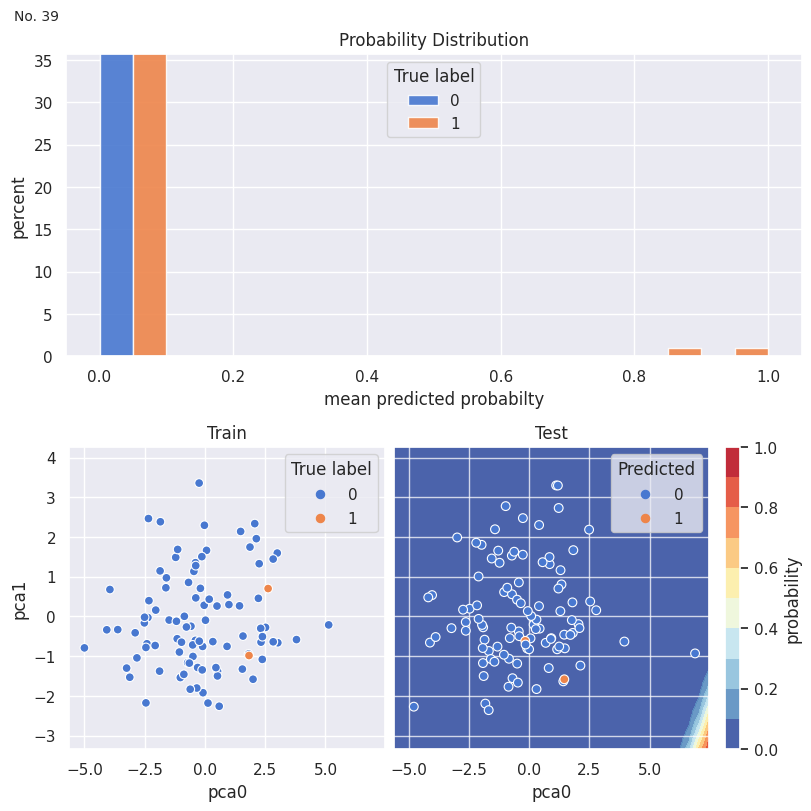

In [16]:
class Example1(PlotHelper):
    '''
    Update Method Steps:
    1. Selects a random subset of `sample` with a approximately size of `train.size * 0.02`.
    2. Performs recourse on the selected subset of 'sample' while preserving their original labels.
    3. Replaces a corresponding part of the training set with the updated samples.
    4. Refits the model with the modified training data.
    '''

    #add first k              k maybe 40% 80% 100%

    def update(self, model: nn.Module, train: Dataset, sample: Dataset):
        #get model parameters before model updated
        modelParams = list(model.parameters())
        weights = deepcopy(modelParams[0].data.reshape(-1))
        bias = deepcopy(modelParams[1].data)
        # print("Before update: ")
        # print(weights,bias)


        size = train.x.shape[0] // 4
        i = np.random.choice(sample.x.shape[0], size, False)
        x = sample.x[i]
        # print("x:",x)

        with pt.no_grad():
            y_prob: pt.Tensor = model(x)

        # print("predict: ",y_prob.data)
        y_pred = y_prob.flatten() < 0.5
        sub_sample = Dataset(x[y_pred], pt.ones((y_pred.count_nonzero(), 1)))

        recourse(model, sub_sample, 10)
        # recourse(model, sub_sample, 10,None,None)

        x[y_pred] = sub_sample.x

        j = np.random.choice(train.x.shape[0], size, False)
        train.x[j] = x
        train.y[j, 0] = (~y_pred).float()

        val_data = Dataset(train.x[j], train.y[j])
        self.validation_list.append(val_data)
        sample_model = LogisticRegression(val_data.x.shape[1], 1)
        sample_model.train()
        training(sample_model, val_data, 30)
        self.Aj_tide_list.append(self.calculate_accuracy(sample_model(val_data.x), val_data.y))

        #紀錄新增進來的sample資料
        self.addEFTDataFrame(j)


        training(model, train, 50)

        # calculate the overall accuracy
        self.overall_acc_list.append(self.calculate_AA(model, self.validation_list))
        # evaluate memory stability
        self.memory_stability_list.append(self.calculate_BWT(model, self.validation_list, self.Ajj_performance_list))
        # evaluate memory plasticity
        self.memory_plasticity_list.append(self.calculate_FWT(self.Ajj_performance_list, self.Aj_tide_list))


        #紀錄Fail_to_Recourse
        with pt.no_grad():
            y_prob: pt.Tensor = model(x[y_pred])

        # print("x[y_pred] : ",x[y_pred])
        # print("after model update:")
        # print("y_prob:",y_prob)
        # print("y_prob[y_prob < 0.5]",y_prob[y_prob < 0.5])
        recourseFailCnt = len(y_prob[y_prob < 0.5])
        # print("recourseFailCnt",recourseFailCnt)
        recourseFailRate = recourseFailCnt / len(x[y_pred])
        # print("recourseFailRate : ",recourseFailRate)
        self.failToRecourse.append(recourseFailRate)

        self.EFTdataframe = self.EFTdataframe.assign(updateRounds = self.EFTdataframe['updateRounds'] + 1)
        self.round = self.round + 1


        #updated model predict the data with new sample
        data = np.vstack(self.EFTdataframe['x'])
        with pt.no_grad():
            y_pred = model(pt.tensor(data,dtype = pt.float))

        #set prob 0.5 as threshold
        predictValue = deepcopy(y_pred.data)
        predictValue[predictValue > 0.5] = 1.0
        predictValue[predictValue < 0.5] = 0.0
        predictValue = predictValue.numpy().T.reshape(-1)
        # print("predictValue: ",predictValue)
        # print("data type: ",type(predictValue))

        #store the updated model predict value
        for i in self.EFTdataframe.index:
            self.EFTdataframe.at[i,'Predict'].append(predictValue[i])
         # self.EFTdataframe.loc[predictValue.numpy().T.reshape(-1) != self.EFTdataframe['Predict'],['flip_times']] += 1

         #check whether the output flip out
        for i in self.EFTdataframe.index:
            predictLength = len(self.EFTdataframe.at[i,'Predict'])
            # if predictLength > 1 and (self.EFTdataframe.at[i,'Predict'][predictLength - 2] != self.EFTdataframe.at[i,'Predict'][predictLength - 1]):
            if predictLength > 1 and (self.EFTdataframe.at[i,'Predict'][-2] != self.EFTdataframe.at[i,'Predict'][-1]):
                # self.EFTdataframe.loc[(self.EFTdataframe['rounds'] - self.EFTdataframe['startRounds'] > 1) and self.EFTdataframe['Predict'][self.round - 2] != self.EFTdataframe['Predict'][self.round - 1] ,['flip_times']] += 1
                self.EFTdataframe.at[i,'flip_times'] += 1

        #update EFP values
        self.EFTdataframe.loc[(self.EFTdataframe['updateRounds'] - 1) > 0,['EFT']] = self.EFTdataframe['flip_times'] / (self.EFTdataframe['updateRounds'] - 1)

        for i in self.EFTdataframe.index:
            if len(self.EFTdataframe.at[i,'Predict']) > 1:
                # self.EFTdataframe.at[i,'EFTList'].append(self.EFTdataframe.at[i,'flip_times'] / self.EFTdataframe.at[i,'rounds'])
                self.EFTdataframe.at[i,'EFTList'].append(self.EFTdataframe.at[i,'EFT'])

        display(self.EFTdataframe)
        #calculate the PDt
        modelParams = list(model.parameters())
        modelParameter = np.concatenate((weights,bias))
        resultParameter = np.concatenate((modelParams[0].data.reshape(-1),modelParams[1].data))
        # print("Before update: ")
        # print(weights,bias)
        # print("After update: ")
        # print(modelParams[0].data.reshape(-1),modelParams[1].data)

        parameterL2 = np.linalg.norm(resultParameter - modelParameter)

        self.PDt.append(parameterL2)

# print(train.x)
# print(train.y)
ex1 = Example1(model, pca, train, test, sample)
ani1 = ex1.animate_all(240)
ani1.save('ex1.gif')

# ex1.draw_PDt()
ex1.draw_EFT()
ex1.draw_PDt()
ex1.draw_EFT(240)
ex1.draw_R20_EFT(240,23)
ex1.draw_R20_EFT(240,40)
ex1.draw_R20_EFT(240,58)
ex1.draw_Fail_to_Recourse()
display(ex1.EFTdataframe)
ex1.plot_matricsA()


In [ ]:
class Example6(PlotHelper):
    '''
    Update Method Steps:
    1. Selects a random subset of `sample` with a size of `train.size * 0.02`.
    2. Performs recourse on the selected samples.
    3. Randomly relabels samples based on the model's probability scores.
    4. Replaces a corresponding part of the training set with the updated samples.
    5. Refits the model with the modified training data.
    '''

    def update(self, model: nn.Module, train: Dataset, sample: Dataset):
        size = train.x.shape[0] // 10
        i = np.random.choice(sample.x.shape[0], size, False)
        x = sample.x[i]

        with pt.no_grad():
            y_prob: pt.Tensor = model(x)

        y_pred = y_prob.flatten() < 0.5
        sub_sample = Dataset(x[y_pred], pt.full((y_pred.count_nonzero(), 1), 0.6))

        recourse(model, sub_sample, 5)

        x[y_pred] = sub_sample.x

        j = np.random.choice(train.x.shape[0], size, False)

        with pt.no_grad():
            y_prob: pt.Tensor = model(x)

        train.x[j] = x
        train.y[j] = (pt.rand_like(y_prob) > y_prob).float()

        training(model, train, 20)


ex6 = Example6(model, pca, train, test, sample)
ani5 = ex6.animate_all(200)
ani5.save('output/ex5.mp4')

In [ ]:
class Example6(PlotHelper):
    '''
    Update Method Steps:
    1. Selects a random subset of `sample` with a size of `train.size * 0.02`.
    2. Performs recourse on the selected samples.
    3. Randomly relabels samples based on the model's probability scores.
    4. Replaces a corresponding part of the training set with the updated samples.
    5. Refits the model with the modified training data.
    '''
    def update(self, model: nn.Module, train: Dataset, sample: Dataset):
        size = train.x.shape[0] // 10
        i = np.random.choice(sample.x.shape[0], size, False)
        x = sample.x[i]

        with pt.no_grad():
            y_prob: pt.Tensor = model(x)

        y_pred = y_prob.flatten() < 0.5
        sub_sample = Dataset(x[y_pred], pt.full((y_pred.count_nonzero(), 1), 0.6))

        recourse(model, sub_sample, 5, weight)

        x[y_pred] = sub_sample.x

        j = np.random.choice(train.x.shape[0], size, False)

        with pt.no_grad():
            y_prob: pt.Tensor = model(x)

        train.x[j] = x
        train.y[j] = (pt.rand_like(y_prob) > y_prob).float()

        training(model, train, 20)


weight = pt.arange(1, train.x.shape[1] + 1)
print(weight)
# pt.randn(train.x.shape[1])
ex6 = Example6(model, pca, train, test, sample)
ani6 = ex6.animate_all(200)
ani6.save('output/ex6.mp4')

binomial y_pred tensor([False, False,  True, False, False,  True,  True, False, False, False])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,[1.0],0.0,0.0,1.0,0.0,[]
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,[1.0],0.0,0.0,1.0,0.0,[]
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,[1.0],0.0,0.0,1.0,0.0,[]
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,[1.0],0.0,0.0,1.0,0.0,[]
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,[1.0],0.0,0.0,1.0,0.0,[]
...,...,...,...,...,...,...,...,...
105,"[0.0779372975230217, 1.11386239528656, -1.1041...",0.0,[0.0],0.0,0.0,1.0,0.0,[]
106,"[1.8908404111862183, 1.170678734779358, 0.4180...",1.0,[1.0],0.0,0.0,1.0,0.0,[]
107,"[2.121631383895874, 0.1580938994884491, 0.7297...",0.0,[0.0],0.0,0.0,1.0,0.0,[]
108,"[-1.2159669399261475, -0.041672736406326294, -...",1.0,[1.0],0.0,0.0,1.0,0.0,[]


binomial y_pred tensor([False,  True,  True, False, False,  True,  True,  True, False, False])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0]",0.0,0.0,2.0,0.0,[0.0]
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0]",0.0,0.0,2.0,0.0,[0.0]
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0]",0.0,0.0,2.0,0.0,[0.0]
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0]",1.0,0.0,2.0,1.0,[1.0]
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0]",0.0,0.0,2.0,0.0,[0.0]
...,...,...,...,...,...,...,...,...
115,"[-0.19752933084964752, -1.2595627307891846, -0...",1.0,[0.0],0.0,1.0,1.0,0.0,[0.0]
116,"[2.121631383895874, 0.1580938994884491, 0.7297...",0.0,[0.0],0.0,1.0,1.0,0.0,[0.0]
117,"[-0.8929905295372009, 1.6021312475204468, -0.3...",0.0,[0.0],0.0,1.0,1.0,0.0,[0.0]
118,"[-1.4467906951904297, -0.33535706996917725, 1....",1.0,[1.0],0.0,1.0,1.0,0.0,[0.0]


binomial y_pred tensor([ True,  True, False, False, False, False, False,  True, False, False])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0]",1.0,0.0,3.0,0.5,"[0.0, 0.5]"
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0]",0.0,0.0,3.0,0.0,"[0.0, 0.0]"
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0]",0.0,0.0,3.0,0.0,"[0.0, 0.0]"
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0]",2.0,0.0,3.0,1.0,"[1.0, 1.0]"
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0]",0.0,0.0,3.0,0.0,"[0.0, 0.0]"
...,...,...,...,...,...,...,...,...
125,"[-0.14312639832496643, 2.0644943714141846, -1....",0.0,[0.0],0.0,2.0,1.0,0.0,"[0.0, 0.0]"
126,"[-0.37439003586769104, -1.5144140720367432, -0...",0.0,[0.0],0.0,2.0,1.0,0.0,"[0.0, 0.0]"
127,"[0.78657066822052, 1.7073811292648315, 0.36712...",1.0,[1.0],0.0,2.0,1.0,0.0,"[0.0, 0.0]"
128,"[-0.2530868351459503, -0.5911468267440796, 0.1...",0.0,[1.0],0.0,2.0,1.0,0.0,"[0.0, 0.0]"


binomial y_pred tensor([False, False, False,  True, False, False, False,  True, False, False])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0]",1.0,0.0,4.0,0.333333,"[0.0, 0.5, 0.3333333333333333]"
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0]",0.0,0.0,4.0,0.000000,"[0.0, 0.0, 0.0]"
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0]",0.0,0.0,4.0,0.000000,"[0.0, 0.0, 0.0]"
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0]",3.0,0.0,4.0,1.000000,"[1.0, 1.0, 1.0]"
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0]",0.0,0.0,4.0,0.000000,"[0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...
135,"[0.0370066799223423, -0.02008102834224701, 0.8...",0.0,[1.0],0.0,3.0,1.0,0.000000,"[0.0, 0.0, 0.0]"
136,"[2.019371509552002, 1.1144042015075684, 0.1199...",1.0,[0.0],0.0,3.0,1.0,0.000000,"[0.0, 0.0, 0.0]"
137,"[0.8583512306213379, 0.9979543089866638, 0.166...",1.0,[0.0],0.0,3.0,1.0,0.000000,"[0.0, 0.0, 0.0]"
138,"[0.39704665541648865, -0.31267717480659485, 0....",0.0,[0.0],0.0,3.0,1.0,0.000000,"[0.0, 0.0, 0.0]"


binomial y_pred tensor([False,  True,  True, False, False,  True,  True, False,  True, False])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0]",1.0,0.0,5.0,0.25,"[0.0, 0.5, 0.3333333333333333, 0.25]"
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0]",0.0,0.0,5.0,0.00,"[0.0, 0.0, 0.0, 0.0]"
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0]",0.0,0.0,5.0,0.00,"[0.0, 0.0, 0.0, 0.0]"
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0, 1.0]",4.0,0.0,5.0,1.00,"[1.0, 1.0, 1.0, 1.0]"
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0]",0.0,0.0,5.0,0.00,"[0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...
145,"[0.39704665541648865, -0.31267717480659485, 0....",0.0,[0.0],0.0,4.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0]"
146,"[0.7854825854301453, 1.4801831245422363, -0.34...",0.0,[1.0],0.0,4.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0]"
147,"[-0.7950521111488342, -0.4017942547798157, -0....",0.0,[0.0],0.0,4.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0]"
148,"[1.8920564651489258, -1.4714992046356201, -0.5...",1.0,[1.0],0.0,4.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0]"


binomial y_pred tensor([False, False, False, False, False, False, False,  True,  True, False])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0]",1.0,0.0,6.0,0.2,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2]"
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0]",1.0,0.0,6.0,0.2,"[0.0, 0.0, 0.0, 0.0, 0.2]"
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.0,0.0,6.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0]"
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0]",4.0,0.0,6.0,0.8,"[1.0, 1.0, 1.0, 1.0, 0.8]"
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.0,0.0,6.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...
155,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,[0.0],0.0,5.0,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0]"
156,"[0.0488484650850296, -0.23657293617725372, -0....",0.0,[0.0],0.0,5.0,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0]"
157,"[0.8074191808700562, -0.08900053799152374, 0.5...",0.0,[0.0],0.0,5.0,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0]"
158,"[-2.191253900527954, -0.45976462960243225, -0....",0.0,[0.0],0.0,5.0,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0]"


binomial y_pred tensor([False,  True,  True, False, False,  True, False,  True,  True, False])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1.0,0.0,7.0,0.166667,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0]",2.0,0.0,7.0,0.333333,"[0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333]"
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.0,0.0,7.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0]",5.0,0.0,7.0,0.833333,"[1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334]"
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.0,0.0,7.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...
165,"[1.8908404111862183, 1.170678734779358, 0.4180...",1.0,[1.0],0.0,6.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
166,"[-0.7133108973503113, 1.7347627878189087, 0.43...",0.0,[0.0],0.0,6.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
167,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,[0.0],0.0,6.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
168,"[0.0863986387848854, -1.3315123319625854, 2.34...",1.0,[1.0],0.0,6.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


binomial y_pred tensor([False, False, False, False, False,  True, False, False,  True, False])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1.0,0.0,8.0,0.142857,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0]",3.0,0.0,8.0,0.428571,"[0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.0,0.0,8.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0]",5.0,0.0,8.0,0.714286,"[1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.0,0.0,8.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...
175,"[-0.03914402797818184, 1.0752215385437012, -0....",0.0,[0.0],0.0,7.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
176,"[-1.2159669399261475, -0.041672736406326294, -...",1.0,[1.0],0.0,7.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
177,"[-1.1341276168823242, -1.3362696170806885, -0....",1.0,[1.0],0.0,7.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
178,"[0.39704665541648865, -0.31267717480659485, 0....",0.0,[1.0],0.0,7.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


binomial y_pred tensor([ True, False, False,  True, False, False, False, False, False, False])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1.0,0.0,9.0,0.125,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0]",4.0,0.0,9.0,0.500,"[0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.0,0.0,9.0,0.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0]",5.0,0.0,9.0,0.625,"[1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]",1.0,0.0,9.0,0.125,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125]"
...,...,...,...,...,...,...,...,...
185,"[0.1485310196876526, -0.9968671202659607, -0.2...",1.0,[0.0],0.0,8.0,1.0,0.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
186,"[0.9379895925521851, 1.0759341716766357, 0.616...",1.0,[1.0],0.0,8.0,1.0,0.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
187,"[-0.3852560222148895, -0.8501690626144409, 0.7...",1.0,[0.0],0.0,8.0,1.0,0.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
188,"[-1.4168235063552856, -0.6032968759536743, 0.7...",0.0,[1.0],0.0,8.0,1.0,0.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


binomial y_pred tensor([ True, False, False,  True, False, False, False,  True,  True,  True])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,0.0,10.0,0.111111,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",4.0,0.0,10.0,0.444444,"[0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.0,0.0,10.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",6.0,0.0,10.0,0.666667,"[1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",2.0,0.0,10.0,0.222222,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
...,...,...,...,...,...,...,...,...
195,"[-0.7548661828041077, 0.022339239716529846, 0....",0.0,[0.0],0.0,9.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
196,"[-2.351223945617676, -0.11792437732219696, -0....",0.0,[1.0],0.0,9.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
197,"[0.7854825854301453, 1.4801831245422363, -0.34...",0.0,[1.0],0.0,9.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
198,"[0.2066597044467926, 0.6290826201438904, 1.129...",0.0,[0.0],0.0,9.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


binomial y_pred tensor([False,  True, False, False,  True, False, False, False, False,  True])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.0,0.0,11.0,0.2,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",4.0,0.0,11.0,0.4,"[0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.0,0.0,11.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",7.0,0.0,11.0,0.7,"[1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",2.0,0.0,11.0,0.2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
...,...,...,...,...,...,...,...,...
205,"[-2.1027016639709473, 0.4215136468410492, 0.33...",1.0,[1.0],0.0,10.0,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
206,"[-0.3852560222148895, -0.8501690626144409, 0.7...",1.0,[0.0],0.0,10.0,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
207,"[0.5484632849693298, -0.1604500412940979, 0.76...",0.0,[0.0],0.0,10.0,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
208,"[1.2175480127334595, 0.31977805495262146, 1.39...",1.0,[0.0],0.0,10.0,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([ True, False,  True, False, False, False,  True,  True,  True, False])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.0,0.0,12.0,0.272727,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",4.0,0.0,12.0,0.363636,"[0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.0,0.0,12.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",7.0,0.0,12.0,0.636364,"[1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",3.0,0.0,12.0,0.272727,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
...,...,...,...,...,...,...,...,...
215,"[-1.0168944597244263, -1.700072169303894, -0.8...",0.0,[0.0],0.0,11.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
216,"[0.8158390522003174, 0.5027148723602295, -0.44...",1.0,[0.0],0.0,11.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
217,"[1.2175480127334595, 0.31977805495262146, 1.39...",1.0,[0.0],0.0,11.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
218,"[2.5878305435180664, 2.68530535697937, -0.3894...",0.0,[0.0],0.0,11.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([ True, False, False, False,  True, False,  True,  True,  True, False])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.0,0.0,13.0,0.250000,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",4.0,0.0,13.0,0.333333,"[0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,0.0,13.0,0.083333,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",7.0,0.0,13.0,0.583333,"[1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",4.0,0.0,13.0,0.333333,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
...,...,...,...,...,...,...,...,...
225,"[0.6403371095657349, 0.9779082536697388, 1.213...",0.0,[0.0],0.0,12.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
226,"[-1.522334337234497, 0.012169682420790195, -2....",0.0,[0.0],0.0,12.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
227,"[-1.925642967224121, -0.4310844838619232, 1.27...",1.0,[1.0],0.0,12.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
228,"[-0.7930728197097778, 1.0084487199783325, 1.18...",1.0,[0.0],0.0,12.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([ True, False,  True, False, False, False,  True,  True, False,  True])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.0,0.0,14.0,0.230769,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",4.0,0.0,14.0,0.307692,"[0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,0.0,14.0,0.076923,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",7.0,0.0,14.0,0.538462,"[1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",5.0,0.0,14.0,0.384615,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
...,...,...,...,...,...,...,...,...
235,"[0.7020303010940552, 0.4283529222011566, -0.46...",0.0,[0.0],0.0,13.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
236,"[1.6772005558013916, 0.21907156705856323, 0.38...",0.0,[0.0],0.0,13.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
237,"[0.6403371095657349, 0.9779082536697388, 1.213...",0.0,[0.0],0.0,13.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
238,"[-0.23778893053531647, -0.5849044322967529, 0....",1.0,[1.0],0.0,13.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([ True, False,  True,  True, False, False, False,  True, False,  True])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.0,0.0,15.0,0.214286,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",4.0,0.0,15.0,0.285714,"[0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,0.0,15.0,0.071429,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",7.0,0.0,15.0,0.500000,"[1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",5.0,0.0,15.0,0.357143,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
...,...,...,...,...,...,...,...,...
245,"[-0.3117977976799011, -1.7473630905151367, 0.2...",1.0,[0.0],0.0,14.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
246,"[1.4538590908050537, -0.31241732835769653, -0....",1.0,[0.0],0.0,14.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
247,"[-0.3423808515071869, -0.1938551515340805, 0.5...",0.0,[0.0],0.0,14.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
248,"[-0.37439003586769104, -1.5144140720367432, -0...",0.0,[0.0],0.0,14.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False,  True,  True,  True,  True, False,  True,  True])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.0,0.0,16.0,0.200000,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",4.0,0.0,16.0,0.266667,"[0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,0.0,16.0,0.066667,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",7.0,0.0,16.0,0.466667,"[1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",5.0,0.0,16.0,0.333333,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
...,...,...,...,...,...,...,...,...
255,"[0.759442150592804, 0.27982160449028015, 0.565...",1.0,[0.0],0.0,15.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
256,"[-0.26178768277168274, -0.03193388879299164, 0...",1.0,[0.0],0.0,15.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
257,"[0.7020303010940552, 0.4283529222011566, -0.46...",0.0,[0.0],0.0,15.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
258,"[-0.6081535220146179, -1.2433587312698364, -0....",1.0,[1.0],0.0,15.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False,  True,  True, False, False,  True, False,  True, False])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.0,0.0,17.0,0.2500,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",4.0,0.0,17.0,0.2500,"[0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2.0,0.0,17.0,0.1250,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",7.0,0.0,17.0,0.4375,"[1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",5.0,0.0,17.0,0.3125,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
...,...,...,...,...,...,...,...,...
265,"[1.6772005558013916, 0.21907156705856323, 0.38...",0.0,[0.0],0.0,16.0,1.0,0.0000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
266,"[1.5926899909973145, -1.670881986618042, -0.51...",1.0,[1.0],0.0,16.0,1.0,0.0000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
267,"[0.05304703116416931, 0.8849626779556274, -1.4...",1.0,[0.0],0.0,16.0,1.0,0.0000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
268,"[0.6964829564094543, 0.10022523254156113, 0.21...",0.0,[0.0],0.0,16.0,1.0,0.0000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([ True,  True,  True, False,  True,  True, False,  True, False,  True])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5.0,0.0,18.0,0.294118,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",4.0,0.0,18.0,0.235294,"[0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",3.0,0.0,18.0,0.176471,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",7.0,0.0,18.0,0.411765,"[1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",5.0,0.0,18.0,0.294118,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
...,...,...,...,...,...,...,...,...
275,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,[0.0],0.0,17.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
276,"[-1.2159669399261475, -0.041672736406326294, -...",1.0,[1.0],0.0,17.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
277,"[1.1244174242019653, 0.9911531209945679, -0.44...",1.0,[0.0],0.0,17.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
278,"[0.9078524112701416, -0.16648557782173157, -0....",0.0,[0.0],0.0,17.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False,  True, False, False, False, False,  True, False, False,  True])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6.0,0.0,19.0,0.333333,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",5.0,0.0,19.0,0.277778,"[0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",3.0,0.0,19.0,0.166667,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",7.0,0.0,19.0,0.388889,"[1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",5.0,0.0,19.0,0.277778,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
...,...,...,...,...,...,...,...,...
285,"[0.6964829564094543, 0.10022523254156113, 0.21...",0.0,[0.0],0.0,18.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
286,"[0.39704665541648865, -0.31267717480659485, 0....",0.0,[0.0],0.0,18.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
287,"[-0.8128235936164856, -2.074486255645752, 1.62...",0.0,[0.0],0.0,18.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
288,"[-0.4676095247268677, 1.378357172012329, -0.41...",1.0,[1.0],0.0,18.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False,  True, False, False, False,  True, False,  True])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6.0,0.0,20.0,0.315789,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",5.0,0.0,20.0,0.263158,"[0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",4.0,0.0,20.0,0.210526,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",7.0,0.0,20.0,0.368421,"[1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",6.0,0.0,20.0,0.315789,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
...,...,...,...,...,...,...,...,...
295,"[-1.9158689975738525, -0.43840888142585754, -0...",1.0,[1.0],0.0,19.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
296,"[0.6119949817657471, 0.3672342896461487, -0.20...",1.0,[0.0],0.0,19.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
297,"[1.0480836629867554, 0.794426679611206, -0.609...",0.0,[1.0],0.0,19.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
298,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,[1.0],0.0,19.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False,  True, False, False, False,  True, False, False,  True])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6.0,0.0,21.0,0.30,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",6.0,0.0,21.0,0.30,"[0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",5.0,0.0,21.0,0.25,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",7.0,0.0,21.0,0.35,"[1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",6.0,0.0,21.0,0.30,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
...,...,...,...,...,...,...,...,...
305,"[0.6403371095657349, 0.9779082536697388, 1.213...",0.0,[0.0],0.0,20.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
306,"[-2.1027016639709473, 0.4215136468410492, 0.33...",1.0,[0.0],0.0,20.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
307,"[1.2175480127334595, 0.31977805495262146, 1.39...",1.0,[0.0],0.0,20.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
308,"[0.780222475528717, 0.2059607207775116, 0.7508...",1.0,[0.0],0.0,20.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False,  True,  True,  True, False, False,  True,  True,  True, False])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7.0,0.0,22.0,0.333333,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",6.0,0.0,22.0,0.285714,"[0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",5.0,0.0,22.0,0.238095,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",7.0,0.0,22.0,0.333333,"[1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",6.0,0.0,22.0,0.285714,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
...,...,...,...,...,...,...,...,...
315,"[-1.925642967224121, -0.4310844838619232, 1.27...",1.0,[1.0],0.0,21.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
316,"[-1.4467906951904297, -0.33535706996917725, 1....",1.0,[0.0],0.0,21.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
317,"[1.8920564651489258, -1.4714992046356201, -0.5...",1.0,[1.0],0.0,21.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
318,"[0.1485310196876526, -0.9968671202659607, -0.2...",1.0,[1.0],0.0,21.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False,  True,  True, False])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",8.0,0.0,23.0,0.363636,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",6.0,0.0,23.0,0.272727,"[0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.0,0.0,23.0,0.272727,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",7.0,0.0,23.0,0.318182,"[1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",6.0,0.0,23.0,0.272727,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
...,...,...,...,...,...,...,...,...
325,"[0.780222475528717, 0.2059607207775116, 0.7508...",1.0,[0.0],0.0,22.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
326,"[-0.5038936734199524, -1.4821275472640991, 0.3...",1.0,[0.0],0.0,22.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
327,"[0.16769152879714966, 0.508087694644928, -0.32...",0.0,[1.0],0.0,22.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
328,"[0.08189667761325836, 0.05966189503669739, 2.0...",1.0,[0.0],0.0,22.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False,  True, False,  True,  True,  True,  True,  True,  True])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9.0,0.0,24.0,0.391304,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",7.0,0.0,24.0,0.304348,"[0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7.0,0.0,24.0,0.304348,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",8.0,0.0,24.0,0.347826,"[1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",6.0,0.0,24.0,0.260870,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
...,...,...,...,...,...,...,...,...
335,"[-1.9158689975738525, -0.43840888142585754, -0...",1.0,[1.0],0.0,23.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
336,"[0.0779372975230217, 1.11386239528656, -1.1041...",0.0,[1.0],0.0,23.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
337,"[0.16769152879714966, 0.508087694644928, -0.32...",0.0,[0.0],0.0,23.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
338,"[-0.5482150912284851, 1.381719708442688, -0.24...",0.0,[1.0],0.0,23.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([ True, False,  True, False, False,  True, False, False, False,  True])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9.0,0.0,25.0,0.375000,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",7.0,0.0,25.0,0.291667,"[0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7.0,0.0,25.0,0.291667,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",9.0,0.0,25.0,0.375000,"[1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",6.0,0.0,25.0,0.250000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
...,...,...,...,...,...,...,...,...
345,"[1.2175480127334595, 0.31977805495262146, 1.39...",1.0,[0.0],0.0,24.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
346,"[-0.5054495334625244, 0.17281228303909302, -0....",1.0,[0.0],0.0,24.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
347,"[0.8583512306213379, 0.9979543089866638, 0.166...",1.0,[1.0],0.0,24.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
348,"[0.16769152879714966, 0.508087694644928, -0.32...",0.0,[1.0],0.0,24.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False,  True, False, False, False,  True,  True,  True])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10.0,0.0,26.0,0.40,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",7.0,0.0,26.0,0.28,"[0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7.0,0.0,26.0,0.28,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",10.0,0.0,26.0,0.40,"[1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",6.0,0.0,26.0,0.24,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
...,...,...,...,...,...,...,...,...
355,"[-0.5482150912284851, 1.381719708442688, -0.24...",0.0,[1.0],0.0,25.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
356,"[0.759442150592804, 0.27982160449028015, 0.565...",1.0,[0.0],0.0,25.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
357,"[-0.022377334535121918, -0.21068492531776428, ...",1.0,[1.0],0.0,25.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
358,"[-0.2530868351459503, -0.5911468267440796, 0.1...",0.0,[1.0],0.0,25.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False,  True, False, False,  True, False, False,  True])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",11.0,0.0,27.0,0.423077,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",7.0,0.0,27.0,0.269231,"[0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7.0,0.0,27.0,0.269231,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",11.0,0.0,27.0,0.423077,"[1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",6.0,0.0,27.0,0.230769,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
...,...,...,...,...,...,...,...,...
365,"[2.121631383895874, 0.1580938994884491, 0.7297...",0.0,[0.0],0.0,26.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
366,"[0.9964319467544556, -1.4920862913131714, 0.40...",1.0,[1.0],0.0,26.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
367,"[-0.4676095247268677, 1.378357172012329, -0.41...",1.0,[0.0],0.0,26.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
368,"[2.5878305435180664, 2.68530535697937, -0.3894...",0.0,[0.0],0.0,26.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False,  True, False, False,  True])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",11.0,0.0,28.0,0.407407,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",7.0,0.0,28.0,0.259259,"[0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",8.0,0.0,28.0,0.296296,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",11.0,0.0,28.0,0.407407,"[1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",6.0,0.0,28.0,0.222222,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
...,...,...,...,...,...,...,...,...
375,"[-1.2159669399261475, -0.041672736406326294, -...",1.0,[1.0],0.0,27.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
376,"[-0.3852560222148895, -0.8501690626144409, 0.7...",1.0,[1.0],0.0,27.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
377,"[0.6119949817657471, 0.3672342896461487, -0.20...",1.0,[0.0],0.0,27.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
378,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,[0.0],0.0,27.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False,  True,  True, False,  True, False, False, False])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",11.0,0.0,29.0,0.392857,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",7.0,0.0,29.0,0.250000,"[0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.0,0.0,29.0,0.321429,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",12.0,0.0,29.0,0.428571,"[1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",7.0,0.0,29.0,0.250000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
...,...,...,...,...,...,...,...,...
385,"[0.0779372975230217, 1.11386239528656, -1.1041...",0.0,[0.0],0.0,28.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
386,"[0.7020303010940552, 0.4283529222011566, -0.46...",0.0,[0.0],0.0,28.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
387,"[-1.0168944597244263, -1.700072169303894, -0.8...",0.0,[1.0],0.0,28.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
388,"[0.8074191808700562, -0.08900053799152374, 0.5...",0.0,[0.0],0.0,28.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False,  True, False, False,  True, False,  True,  True])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",11.0,0.0,30.0,0.379310,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",7.0,0.0,30.0,0.241379,"[0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",10.0,0.0,30.0,0.344828,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",13.0,0.0,30.0,0.448276,"[1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",7.0,0.0,30.0,0.241379,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
...,...,...,...,...,...,...,...,...
395,"[-1.9158689975738525, -0.43840888142585754, -0...",1.0,[1.0],0.0,29.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
396,"[0.9379895925521851, 1.0759341716766357, 0.616...",1.0,[0.0],0.0,29.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
397,"[-2.1027016639709473, 0.4215136468410492, 0.33...",1.0,[1.0],0.0,29.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
398,"[1.4538590908050537, -0.31241732835769653, -0....",1.0,[0.0],0.0,29.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False,  True,  True,  True,  True, False,  True, False])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",11.0,0.0,31.0,0.366667,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",7.0,0.0,31.0,0.233333,"[0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",11.0,0.0,31.0,0.366667,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",13.0,0.0,31.0,0.433333,"[1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",7.0,0.0,31.0,0.233333,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
...,...,...,...,...,...,...,...,...
405,"[0.5484632849693298, -0.1604500412940979, 0.76...",0.0,[0.0],0.0,30.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
406,"[1.256520390510559, -0.7665912508964539, -1.08...",1.0,[0.0],0.0,30.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
407,"[0.0863986387848854, -1.3315123319625854, 2.34...",1.0,[0.0],0.0,30.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
408,"[0.78657066822052, 1.7073811292648315, 0.36712...",1.0,[0.0],0.0,30.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False,  True, False,  True,  True, False,  True, False])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",11.0,0.0,32.0,0.354839,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",8.0,0.0,32.0,0.258065,"[0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",11.0,0.0,32.0,0.354839,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",13.0,0.0,32.0,0.419355,"[1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",7.0,0.0,32.0,0.225806,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
...,...,...,...,...,...,...,...,...
415,"[-0.7930728197097778, 1.0084487199783325, 1.18...",1.0,[1.0],0.0,31.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
416,"[-0.37439003586769104, -1.5144140720367432, -0...",0.0,[0.0],0.0,31.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
417,"[0.8074191808700562, -0.08900053799152374, 0.5...",0.0,[0.0],0.0,31.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
418,"[0.05304703116416931, 0.8849626779556274, -1.4...",1.0,[0.0],0.0,31.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False,  True,  True, False,  True, False,  True, False, False])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",11.0,0.0,33.0,0.34375,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",8.0,0.0,33.0,0.25000,"[0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",11.0,0.0,33.0,0.34375,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",13.0,0.0,33.0,0.40625,"[1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",7.0,0.0,33.0,0.21875,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
...,...,...,...,...,...,...,...,...
425,"[0.0779372975230217, 1.11386239528656, -1.1041...",0.0,[1.0],0.0,32.0,1.0,0.00000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
426,"[2.019371509552002, 1.1144042015075684, 0.1199...",1.0,[1.0],0.0,32.0,1.0,0.00000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
427,"[-1.1341276168823242, -1.3362696170806885, -0....",1.0,[0.0],0.0,32.0,1.0,0.00000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
428,"[-0.022377334535121918, -0.21068492531776428, ...",1.0,[0.0],0.0,32.0,1.0,0.00000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([ True, False,  True, False,  True,  True,  True,  True, False, False])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",11.0,0.0,34.0,0.333333,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",9.0,0.0,34.0,0.272727,"[0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",11.0,0.0,34.0,0.333333,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",13.0,0.0,34.0,0.393939,"[1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",7.0,0.0,34.0,0.212121,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
...,...,...,...,...,...,...,...,...
435,"[-2.351223945617676, -0.11792437732219696, -0....",0.0,[1.0],0.0,33.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
436,"[0.9078524112701416, -0.16648557782173157, -0....",0.0,[1.0],0.0,33.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
437,"[-1.4106119871139526, 0.7384451627731323, 1.30...",1.0,[0.0],0.0,33.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
438,"[0.2447846233844757, -2.9538235664367676, 0.20...",1.0,[0.0],0.0,33.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False,  True, False,  True, False, False, False, False,  True, False])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",11.0,0.0,35.0,0.323529,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",9.0,0.0,35.0,0.264706,"[0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",11.0,0.0,35.0,0.323529,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",13.0,0.0,35.0,0.382353,"[1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",7.0,0.0,35.0,0.205882,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
...,...,...,...,...,...,...,...,...
445,"[-1.4467906951904297, -0.33535706996917725, 1....",1.0,[0.0],0.0,34.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
446,"[0.08795009553432465, -1.0686280727386475, 0.1...",0.0,[0.0],0.0,34.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
447,"[-0.3117977976799011, -1.7473630905151367, 0.2...",1.0,[0.0],0.0,34.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
448,"[-0.2284725457429886, -0.3633120059967041, 0.9...",0.0,[0.0],0.0,34.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False,  True,  True,  True, False, False, False, False, False])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",11.0,0.0,36.0,0.314286,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",9.0,0.0,36.0,0.257143,"[0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",11.0,0.0,36.0,0.314286,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",13.0,0.0,36.0,0.371429,"[1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",7.0,0.0,36.0,0.200000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
...,...,...,...,...,...,...,...,...
455,"[2.121631383895874, 0.1580938994884491, 0.7297...",0.0,[1.0],0.0,35.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
456,"[-0.5054495334625244, 0.17281228303909302, -0....",1.0,[0.0],0.0,35.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
457,"[-2.191253900527954, -0.45976462960243225, -0....",0.0,[0.0],0.0,35.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
458,"[0.0863986387848854, -1.3315123319625854, 2.34...",1.0,[0.0],0.0,35.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([ True, False, False, False, False, False,  True,  True, False, False])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",11.0,0.0,37.0,0.305556,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",10.0,0.0,37.0,0.277778,"[0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",11.0,0.0,37.0,0.305556,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",13.0,0.0,37.0,0.361111,"[1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",7.0,0.0,37.0,0.194444,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
...,...,...,...,...,...,...,...,...
465,"[-0.14312639832496643, 2.0644943714141846, -1....",0.0,[1.0],0.0,36.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
466,"[1.256520390510559, -0.7665912508964539, -1.08...",1.0,[1.0],0.0,36.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
467,"[-1.4106119871139526, 0.7384451627731323, 1.30...",1.0,[0.0],0.0,36.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
468,"[-1.522334337234497, 0.012169682420790195, -2....",0.0,[1.0],0.0,36.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([ True, False, False,  True, False,  True, False, False,  True, False])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",11.0,0.0,38.0,0.297297,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",10.0,0.0,38.0,0.270270,"[0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",11.0,0.0,38.0,0.297297,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",13.0,0.0,38.0,0.351351,"[1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",8.0,0.0,38.0,0.216216,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
...,...,...,...,...,...,...,...,...
475,"[0.4784587025642395, 0.05013802647590637, 0.90...",1.0,[0.0],0.0,37.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
476,"[0.9172489047050476, 1.168365240097046, 0.1266...",1.0,[0.0],0.0,37.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
477,"[0.5484632849693298, -0.1604500412940979, 0.76...",0.0,[0.0],0.0,37.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
478,"[-1.4168235063552856, -0.6032968759536743, 0.7...",0.0,[0.0],0.0,37.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([ True, False, False, False,  True, False, False, False, False, False])


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",12.0,0.0,39.0,0.315789,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",10.0,0.0,39.0,0.263158,"[0.0, 0.0, 0.0, 0.0, 0.2, 0.3333333333333333, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",11.0,0.0,39.0,0.289474,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",13.0,0.0,39.0,0.342105,"[1.0, 1.0, 1.0, 1.0, 0.8, 0.8333333333333334, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",9.0,0.0,39.0,0.236842,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.2..."
...,...,...,...,...,...,...,...,...
485,"[0.780222475528717, 0.2059607207775116, 0.7508...",1.0,[1.0],0.0,38.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
486,"[-0.22821752727031708, -0.6645854711532593, 0....",1.0,[0.0],0.0,38.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
487,"[1.256520390510559, -0.7665912508964539, -1.08...",1.0,[1.0],0.0,38.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
488,"[0.8569755554199219, -0.18509764969348907, 0.9...",0.0,[1.0],0.0,38.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


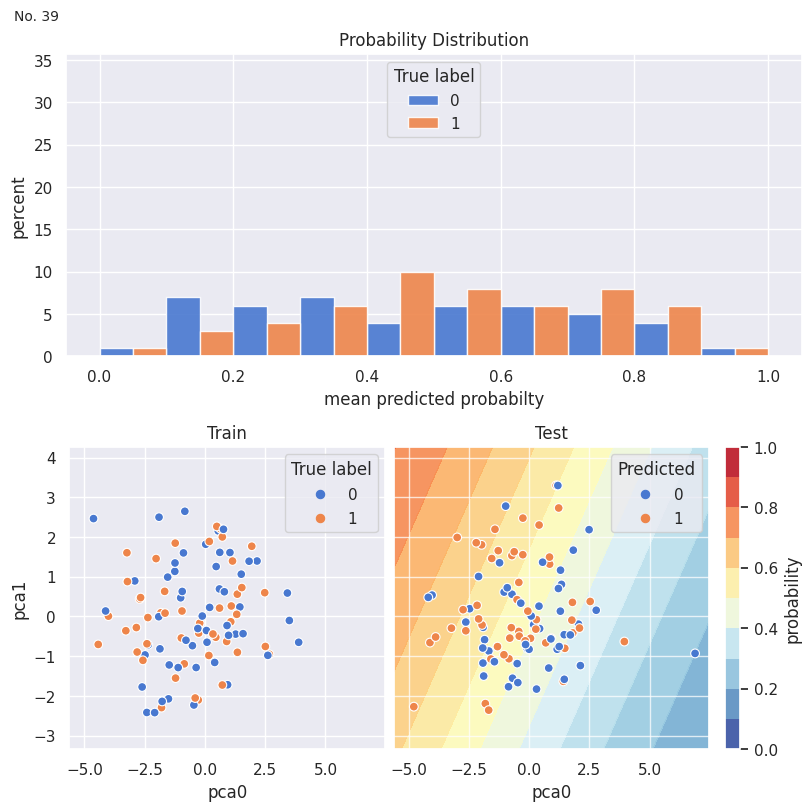

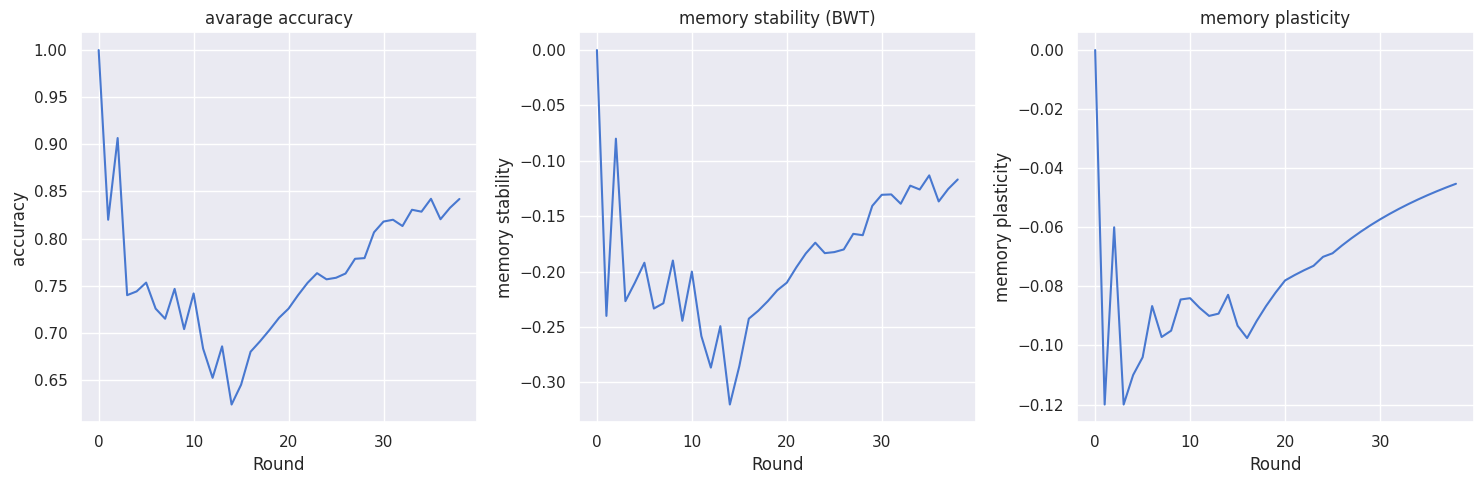

In [18]:
#主要都寫在裡面，其他的還沒加
class Example8(PlotHelper):
    '''
    Update Method Steps:
    1. Selects a random subset of `sample` with a size of `train.size * 0.02`.
    2. Performs recourse on the selected samples with binomial distributed destination.
    3. Randomly relabels samples based on the model's probability scores.
    4. Replaces a corresponding part of the training set with the updated samples.
    5. Refits the model with the modified training data.
    '''

    def update(self, model: nn.Module, train: Dataset, sample: Dataset):
        modelParams = list(model.parameters())
        weights = deepcopy(modelParams[0].data.reshape(-1))
        bias = deepcopy(modelParams[1].data)
        # Selects a random subset of `sample` with a size of `train.size * 0.02`
        size = train.x.shape[0] // 10
        i = np.random.choice(sample.x.shape[0], size, False)
        x = sample.x[i]

        with pt.no_grad():
            y_prob: pt.Tensor = model(x)
        # print("y_prob :",y_prob)
        y_pred = y_prob.flatten() < 0.5
        # print("y_pred :",y_pred)

        # Performs recourse on the selected samples with binomial distributed destination.
        binomialData = np.random.binomial(1,0.6,np.count_nonzero(y_pred)).astype(bool)
        # print("binomial data: ",binomialData)
        y_pred[y_pred == True] = pt.from_numpy(binomialData)
        print("binomial y_pred",y_pred)
        # print("x : ",x)
        # print("x[y_pred] : ",x[y_pred])
        sub_sample = Dataset(x[y_pred], pt.full((y_pred.count_nonzero(), 1), 0.6))

        recourse(model, sub_sample, 5)

        x[y_pred] = sub_sample.x

        #Randomly relabels samples based on the model's probability scores.
        j = np.random.choice(train.x.shape[0], size, False)

        with pt.no_grad():
            y_prob: pt.Tensor = model(x)

        # print("y_prob : ",y_prob)
        # print("y_prob[y_pred] :",y_prob[y_pred])

        # Replaces a corresponding part of the training set with the updated samples.
        train.x[j] = x
        train.y[j] = (pt.rand_like(y_prob) > y_prob).float()

        val_data = Dataset(train.x[j], train.y[j])
        self.validation_list.append(val_data)
        sample_model = LogisticRegression(val_data.x.shape[1], 1)
        sample_model.train()
        training(sample_model, val_data, 30)
        self.Aj_tide_list.append(self.calculate_accuracy(sample_model(val_data.x), val_data.y))

        # #紀錄新增進來的sample資料
        self.addEFTDataFrame(j)

        training(model, train, 20)

        #紀錄Fail_to_Recourse
        if len(x[y_pred]) > 0:
            with pt.no_grad():
                y_prob: pt.Tensor = model(x[y_pred])

            # print("x[y_pred] : ",x[y_pred])
            # print("after model update:")
            # print("y_prob:",y_prob)
            # print("y_prob[y_prob < 0.5]",y_prob[y_prob < 0.5])
            recourseFailCnt = len(y_prob[y_prob < 0.5])
            # print("recourseFailCnt",recourseFailCnt)
            recourseFailRate = recourseFailCnt / len(x[y_pred])
            # print("recourseFailRate : ",recourseFailRate)
            self.failToRecourse.append(recourseFailRate)
        else:
            print("no Recourse:")
            self.failToRecourse.append(0)



        self.EFTdataframe = self.EFTdataframe.assign(updateRounds = self.EFTdataframe['updateRounds'] + 1)
        self.round = self.round + 1

        #updated model predict the data with new sample
        data = np.vstack(self.EFTdataframe['x'])
        with pt.no_grad():
            y_pred = model(pt.tensor(data,dtype = pt.float))
        # print(y_pred)
        predictValue = deepcopy(y_pred.data)
        predictValue[predictValue > 0.5] = 1.0
        predictValue[predictValue < 0.5] = 0.0
        predictValue = predictValue.numpy().T.reshape(-1)
        # print("predictValue: ",predictValue)
        # print("data type: ",type(predictValue))
        for i in self.EFTdataframe.index:
            # for j in predictValue.numpy().T.reshape(-1):
            self.EFTdataframe.at[i,'Predict'].append(predictValue[i])


        # self.EFTdataframe.loc[predictValue.numpy().T.reshape(-1) != self.EFTdataframe['Predict'],['flip_times']] += 1
        for i in self.EFTdataframe.index:
            predictLength = len(self.EFTdataframe.at[i,'Predict'])
            # if predictLength > 1 and (self.EFTdataframe.at[i,'Predict'][predictLength - 2] != self.EFTdataframe.at[i,'Predict'][predictLength - 1]):
            if predictLength > 1 and (self.EFTdataframe.at[i,'Predict'][-2] != self.EFTdataframe.at[i,'Predict'][-1]):
                # self.EFTdataframe.loc[(self.EFTdataframe['rounds'] - self.EFTdataframe['startRounds'] > 1) and self.EFTdataframe['Predict'][self.round - 2] != self.EFTdataframe['Predict'][self.round - 1] ,['flip_times']] += 1
                self.EFTdataframe.at[i,'flip_times'] += 1

        # self.EFTdataframe = self.EFTdataframe.assign(Predict = predictValue)

        #update EFP values
        # self.EFTdataframe['EFT'] = self.EFTdataframe['flip_times'] / self.EFTdataframe['rounds']
        self.EFTdataframe.loc[(self.EFTdataframe['updateRounds'] - 1) > 0,['EFT']] = self.EFTdataframe['flip_times'] / (self.EFTdataframe['updateRounds'] - 1)

        for i in self.EFTdataframe.index:
            if len(self.EFTdataframe.at[i,'Predict']) > 1:
                # self.EFTdataframe.at[i,'EFTList'].append(self.EFTdataframe.at[i,'flip_times'] / self.EFTdataframe.at[i,'rounds'])
                self.EFTdataframe.at[i,'EFTList'].append(self.EFTdataframe.at[i,'EFT'])
        # else:
        #     self.EFTdataframe = self.EFTdataframe.assign(Predict = predictValue)
        # display(self.EFTdataframe[self.EFTdataframe['flip_times'] > 0])
        display(self.EFTdataframe)

        #calculate the PDt
        modelParams = list(model.parameters())
        modelParameter = np.concatenate((weights,bias))
        resultParameter = np.concatenate((modelParams[0].data.reshape(-1),modelParams[1].data))

        parameterL2 = np.linalg.norm(resultParameter - modelParameter)

        self.PDt.append(parameterL2)



ex8 = Example8(model, pca, train, test, sample)
ani8 = ex8.animate_all(240)
ani8.save('ex8.gif')

ex8.draw_PDt()
ex8.draw_EFT(240)
ex8.draw_R20_EFT(240,23)
ex8.draw_R20_EFT(240,40)
ex8.draw_R20_EFT(240,58)
print(ex8.failToRecourse)
ex8.draw_Fail_to_Recourse()
display(ex8.EFTdataframe)
ex1.plot_matricsA()

In [ ]:
a = [i for i in range(40,240,40)]
print(a)
print(len(a))
b = [i for i in range(1,len(a) + 1,1)]
print(b)

[40, 80, 120, 160, 200]
5
[1, 2, 3, 4, 5]
0
1
2
3
4
